# Multi-Table synthesis 

### How to synthesize data from a database schema

Relational databases or RDBMS are a type of data storage that allows users to access data that is stored in various tables and are connected by unique ID or "keys". They are here for a while and they serve a variety of different use-cases, as they offer benefits such as security and reliability. 

For many data science use-cases a single-table model is usually the go to, but the truth is that RDBMS and table like storages are important for some use-cases, such as systems testing, replicating a database for customer segmentation or even for data migrations between on-prem and the cloud. 

YData Fabric offers an easy to use and familiar interface through the SDK to support Multi-Table Synthesis. With the SDK and a few lines of code, users are able to replicate sull relation databases while maintining the consistency of all the keys but also the statistical information of cross-tables relations. 

[Berka](https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions) is the dataset chosen to demo Fabric MultiTable synthesis properties & interface. 

#### Import required packages

In [ ]:
import os
import sys
from typing import List, Union, Set
import numpy as np
from pathlib import Path

import pandas as pd
from numpy.random import random, choice
import matplotlib.pyplot as plt

from ydata.connectors import GCSConnector
from ydata.connectors.filetype import FileType
from ydata.utils.formats import read_json

from ydata.synthesizers.timeseries.model import TimeSeriesSynthesizer
from ydata.metadata import Metadata
from ydata.dataset import Dataset
from ydata.utils.data_types import DataType, VariableType
from ydata.dataset.dataset_type import DatasetType

## Getting the data from and RDBMS

#### MySQL Connector creation

In [ ]:
from ydata.connectors.storages.rdbms_connector import MySQLConnector

USERNAME = 'add-username'
PASSWORD = 'add-password'
HOSTNAME = 'add-hostname'
PORT = '3306'
DATABASE_NAME = 'add-database'

conn_str = {
    "hostname": f'{HOSTNAME}',
    "username":f'{USERNAME}',
    "password": f'{PASSWORD}',
    "port": f'{PORT}',
    "database": f'{DATABASE_NAME}'
}

conn = MySQLConnector(conn_string=conn_str)

In [ ]:
data = conn.read_database()

In [6]:
##Showing one of the tables values
data['loan'].to_pandas()

,loan_id,account_id,date,amount,duration,payments,status
idx,,,,,,,
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A
...,...,...,...,...,...,...,...
677,4989,105,1998-12-05,352704,48,7348.0,C
678,5221,1284,1998-12-05,52512,12,4376.0,C
679,6402,6922,1998-12-06,139488,24,5812.0,C


## Synthesizer definition and training

#### Setting the Metadata parameters

In a relational database schema, some tables might refer to time-series datasets but others might just hold data attrbitutes such as as customers information.

In this example, `Berka` database  transaction table can be considered as time-series, and for that reason, there was the need to set both the table **trans** as timeseries type and the column *data*  as the table time order reference (**sortbykey**).

In [ ]:
from ydata.metadata.multimetadata import MultiMetadata
from ydata.metadata import Metadata
from ydata.dataset import Dataset

dataset_type = {
    'trans': 'timeseries'
}

dataset_attrs = {
    'trans': {
       'sortbykey': 'date'
    }
}

m = MultiMetadata(data, dataset_attrs=dataset_attrs, dataset_type=dataset_type)

In [12]:
m.dataset_type

{'district': <DatasetType.TABULAR: 'tabular'>,
 'account': <DatasetType.TABULAR: 'tabular'>,
 'client': <DatasetType.TABULAR: 'tabular'>,
 'disp': <DatasetType.TABULAR: 'tabular'>,
 'loan': <DatasetType.TABULAR: 'tabular'>,
 'order': <DatasetType.TABULAR: 'tabular'>,
 'trans': <DatasetType.TIMESERIES: 'timeseries'>,
 'card': <DatasetType.TABULAR: 'tabular'>}

#### Init the synthesizer & training

In [ ]:
from ydata.synthesizers.multitable.model import MultiTableSynthesizer

synth = MultiTableSynthesizer()
synth.fit(data, m)

#### Sampling

Because there is a need to keep tables consistency, in what concerns sampling from trained synthesizers the number of records is set based on a ratio given the original datasource number of records. This allows to ensure not only keys consistency by also, to keep the right cross-tables statistical information.

In [19]:
sample = synth.sample(n_samples=0.1)

INFO: 2022-07-15 12:11:59,668 [SYNTHESIZER] - Start generating model samples.
INFO: 2022-07-15 12:11:59,671 [SYNTHESIZER] - Sample segment (-0.001, 28200.0]
INFO: 2022-07-15 12:12:23,375 [SYNTHESIZER] - Sample segment (28200.0, 56400.0]
INFO: 2022-07-15 12:12:46,019 [SYNTHESIZER] - Sample segment (56400.0, 84600.0]
INFO: 2022-07-15 12:13:09,324 [SYNTHESIZER] - Sample segment (84600.0, 112800.0]
INFO: 2022-07-15 12:13:29,774 [SYNTHESIZER] - Sample segment (112800.0, 141000.0]
INFO: 2022-07-15 12:13:50,286 [SYNTHESIZER] - Sample segment (141000.0, 169200.0]
INFO: 2022-07-15 12:14:15,618 [SYNTHESIZER] - Sample segment (169200.0, 197400.0]
INFO: 2022-07-15 12:14:36,919 [SYNTHESIZER] - Sample segment (197400.0, 225600.0]
INFO: 2022-07-15 12:15:08,180 (0) - Split district
INFO: 2022-07-15 12:15:08,248 (1) - Split client
INFO: 2022-07-15 12:15:08,262 (2) - Split card
INFO: 2022-07-15 12:15:08,333 (3) - Split disp
INFO: 2022-07-15 12:15:08,385 (4) - Split trans
INFO: 2022-07-15 12:15:08,436 (5

### Output tables example

In [24]:
sample['district'].to_pandas()

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
idx,,,,,,,,,,,,,,,,
0,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.000000,10673,4.75,5.0,100,18782,18347
1,48,Rychnov nad Kneznou,east Bohemia,78955,50,24,8,1,9,59.000000,9060,1.78,2.0,124,1655,1717
2,70,Karvina,north Moravia,285387,0,2,8,5,7,90.000000,10177,6.63,8.0,81,9878,10108
3,54,Brno - mesto,south Moravia,387570,0,0,0,1,1,100.000000,9897,1.60,2.0,140,18721,18696
4,48,Rychnov nad Kneznou,east Bohemia,78955,50,24,8,1,9,58.999999,9060,1.78,2.0,124,1655,1717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,75,Prerov,north Moravia,323870,0,0,0,1,1,100.000000,10673,4.75,5.0,100,18782,18347
1978,35,Jablonec n. Nisou,north Bohemia,88768,10,18,5,1,7,36.525190,8867,1.02,1.0,130,3384,3620
1979,35,Jablonec n. Nisou,north Bohemia,88768,10,18,5,1,7,62.373002,8867,1.02,1.0,130,3384,3620


In [25]:
data['district'].to_pandas()

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
idx,,,,,,,,,,,,,,,,
0,11,Praha - zapad,central Bohemia,75637,35,36,9,0,7,36.0,9622,0.45,1.0,154,3475,3529
1,17,Pelhrimov,south Bohemia,74062,99,15,4,2,7,61.0,8114,2.38,3.0,119,1003,1181
2,22,Domazlice,west Bohemia,58400,65,16,4,1,6,52.0,8620,1.10,1.0,100,1089,1117
3,23,Cheb,west Bohemia,87419,21,11,4,3,9,86.0,8624,1.79,3.0,102,2879,3198
4,30,Sokolov,west Bohemia,94812,15,13,8,2,10,82.0,9650,3.38,4.0,100,2985,2804
5,32,Ceska Lipa,north Bohemia,105058,32,19,7,2,10,81.0,9272,2.80,3.0,118,4340,4505
6,35,Jablonec n. Nisou,north Bohemia,88768,10,18,5,1,7,80.0,8867,1.02,1.0,130,3384,3620
7,37,Litomerice,north Bohemia,114006,71,26,6,2,9,62.0,9065,4.46,5.0,123,4147,4166
8,38,Louny,north Bohemia,85852,41,23,4,2,4,60.0,8965,7.08,8.0,104,2653,2822


In [26]:
data['trans'].to_pandas()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
idx,,,,,,,,,,
0,207264,704,1993-01-01,PRIJEM,VKLAD,1000.0,1000.0,,None,NaN
1,171812,576,1993-01-01,PRIJEM,VKLAD,900.0,900.0,,None,NaN
2,695247,2378,1993-01-01,PRIJEM,VKLAD,700.0,700.0,,None,NaN
3,1117247,3818,1993-01-01,PRIJEM,VKLAD,600.0,600.0,,None,NaN
4,771035,2632,1993-01-02,PRIJEM,VKLAD,1100.0,1100.0,,None,NaN
...,...,...,...,...,...,...,...,...,...,...
12040,541762,1843,1993-09-12,VYDAJ,PREVOD NA UCET,2939.0,34595.0,UVER,QR,70984434.0
12041,1106922,3781,1993-09-12,PRIJEM,VKLAD,24033.0,63684.0,,None,NaN
12042,439116,1493,1993-09-12,VYDAJ,PREVOD NA UCET,2264.0,12850.0,SIPO,EF,95543610.0


In [27]:
sample['trans'].to_pandas()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
idx,,,,,,,,,,
0,637742,2177,1993-01-05,PRIJEM,PREVOD Z UCTU,3934.311883,2077.264169,DUCHOD,YZ,62457513.0
1,439036,1493,1993-01-13,PRIJEM,PREVOD Z UCTU,6866.578138,7278.147301,DUCHOD,AB,54522466.0
2,1049882,3592,1993-01-10,PRIJEM,PREVOD Z UCTU,7171.159240,10548.813799,DUCHOD,MN,73166322.0
3,480217,1730,1993-01-13,PRIJEM,PREVOD Z UCTU,14870.010477,26771.414281,DUCHOD,UV,45134812.0
4,579374,1972,1993-01-07,PRIJEM,PREVOD Z UCTU,4586.134395,2533.230097,DUCHOD,UV,14132887.0
...,...,...,...,...,...,...,...,...,...,...
679,810148,2762,1993-09-02,VYDAJ,VYBER,2523.830857,52505.640524,,,0.0
680,840180,2762,1993-09-02,VYDAJ,VYBER,11419.236906,111239.843940,,,0.0
681,810265,2762,1993-09-02,VYDAJ,VYBER,126.055465,32987.285277,,,0.0


#### Plots for comparision

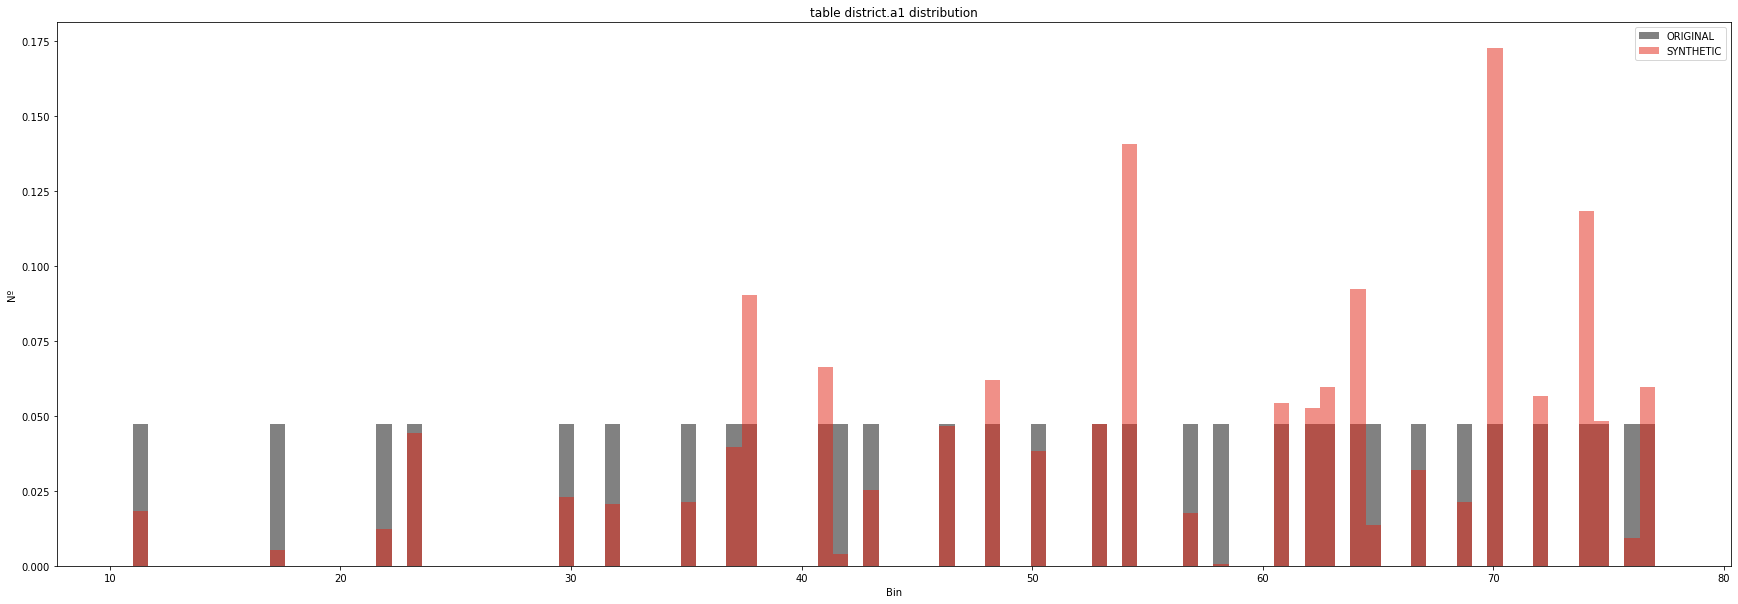

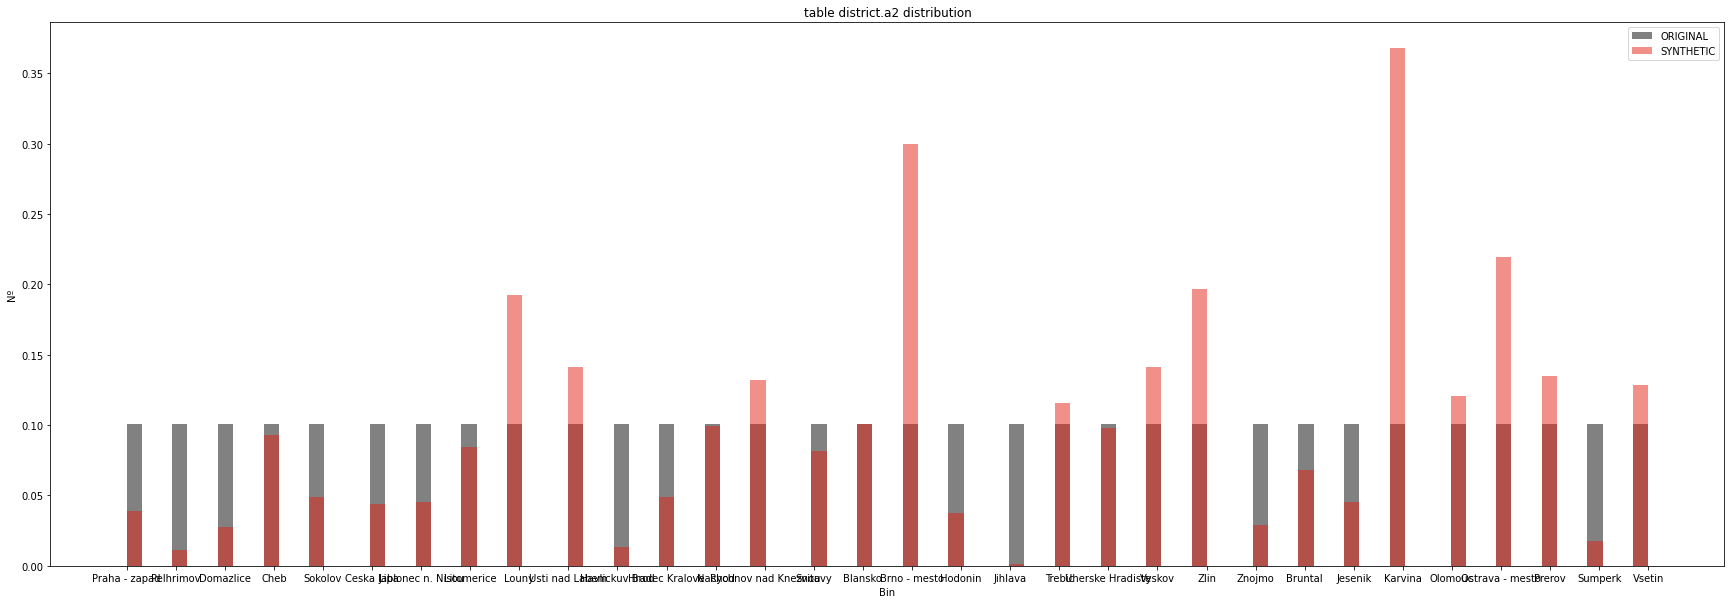

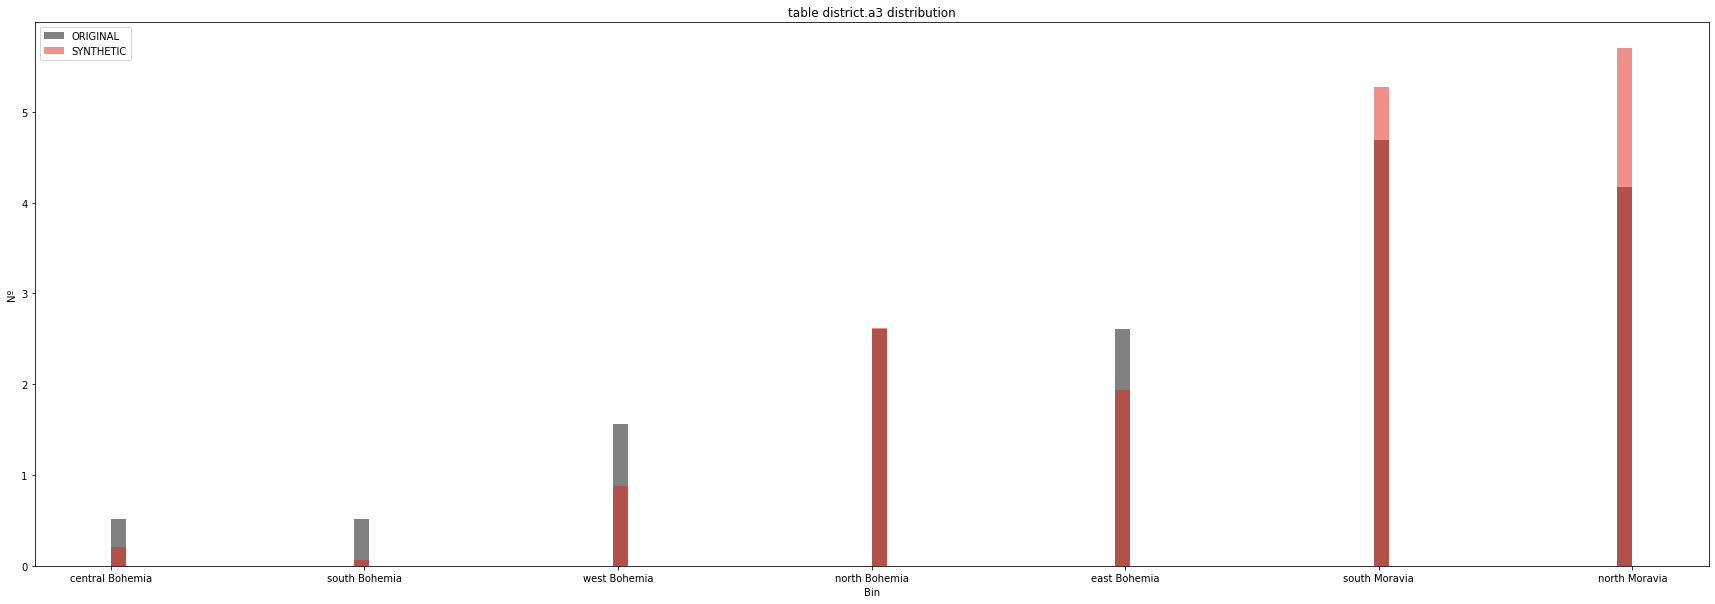

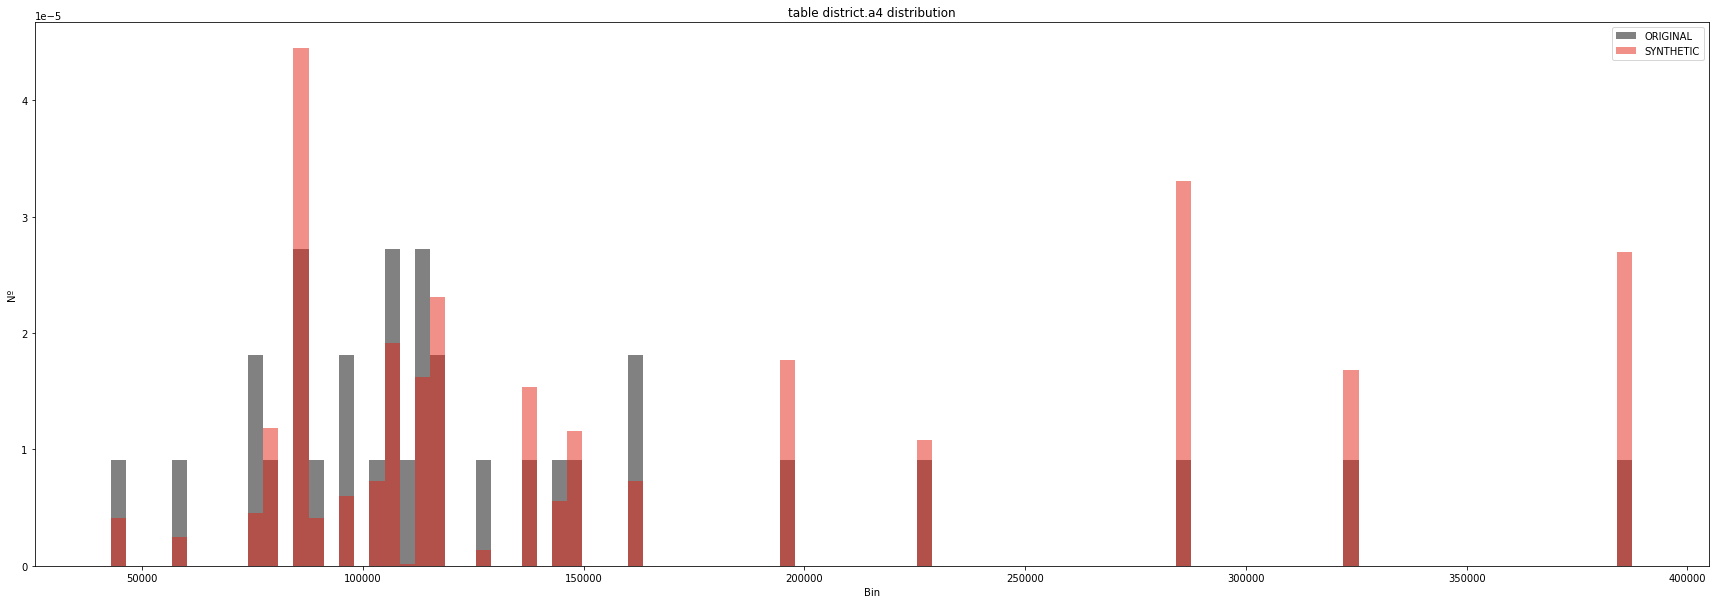

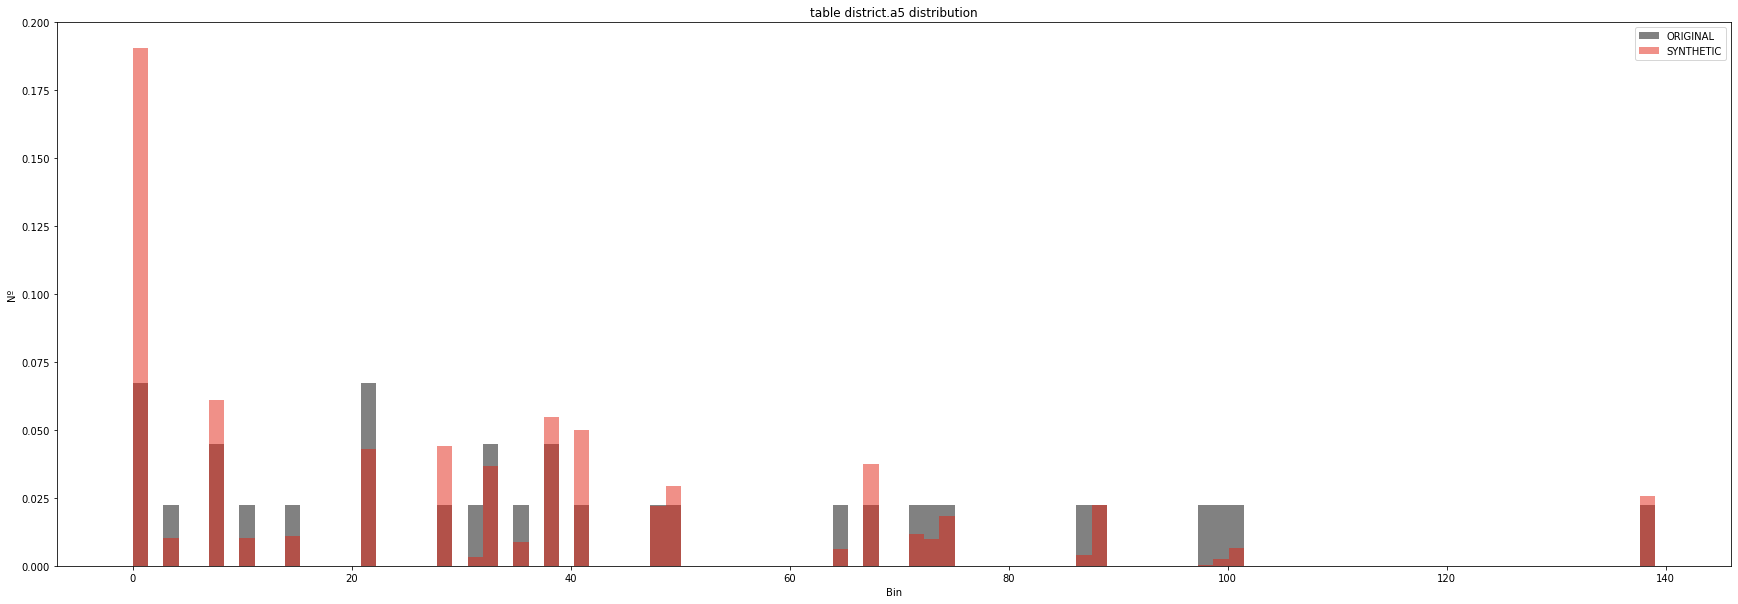

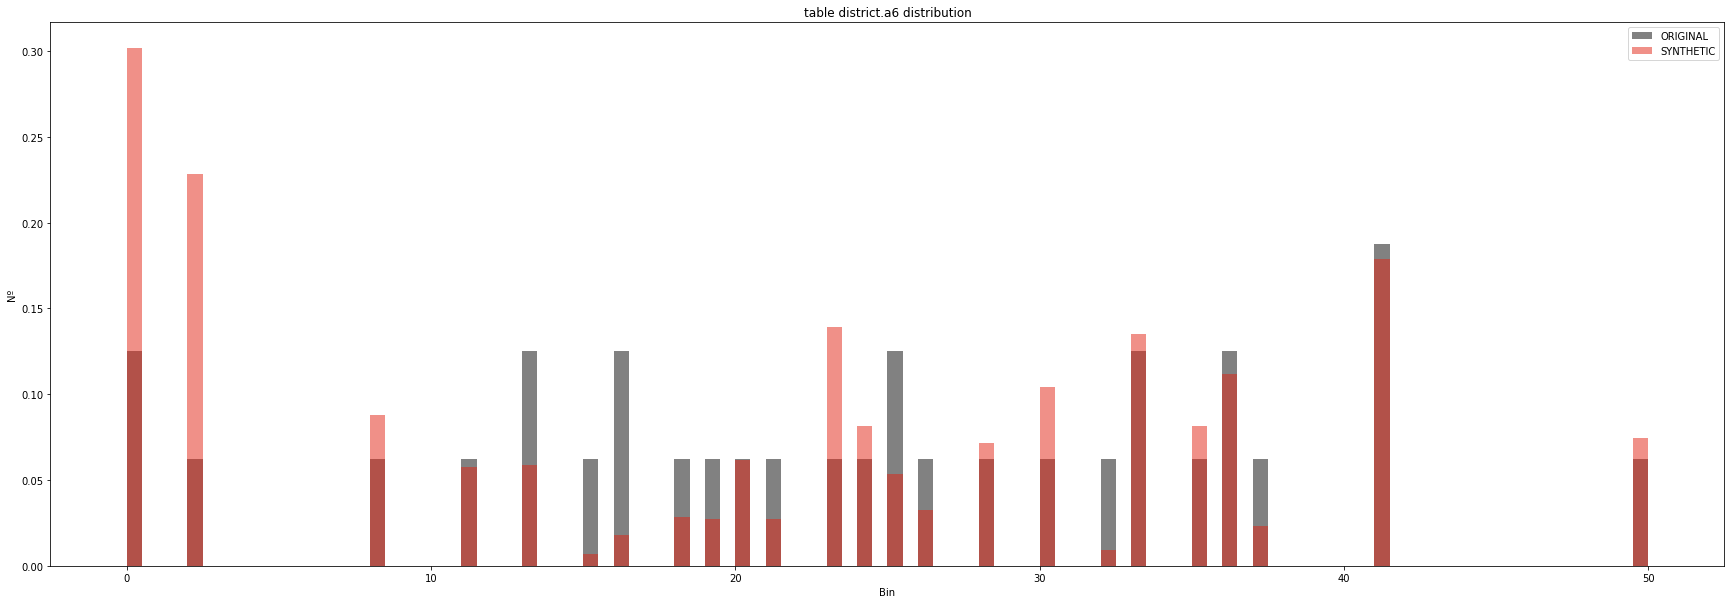

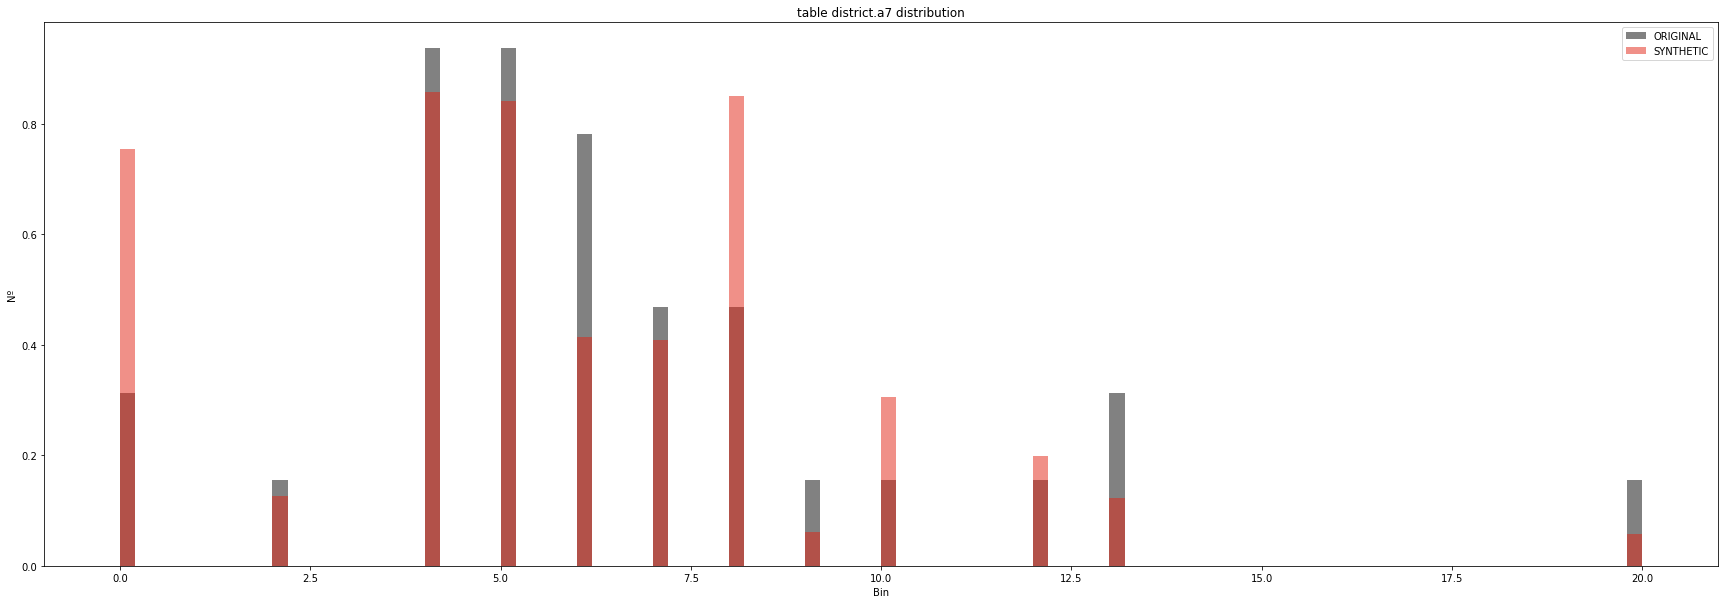

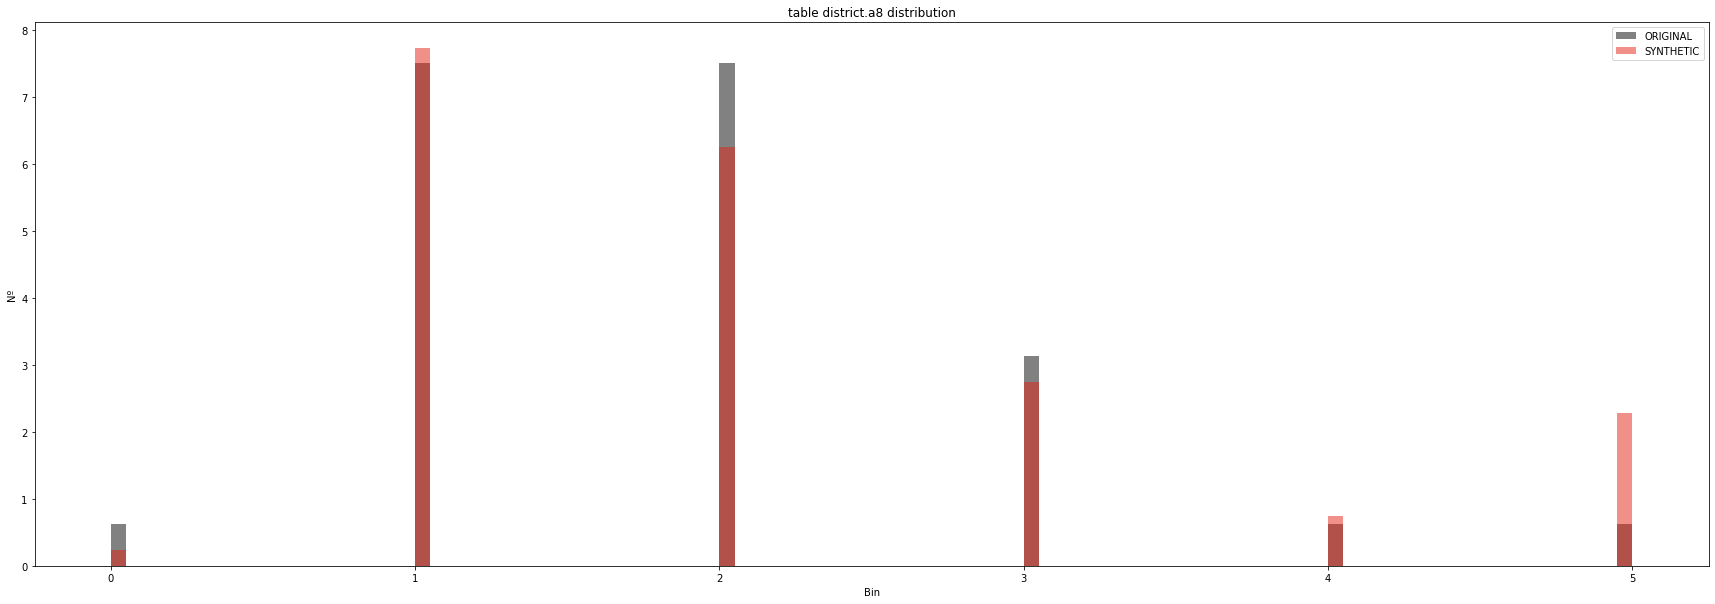

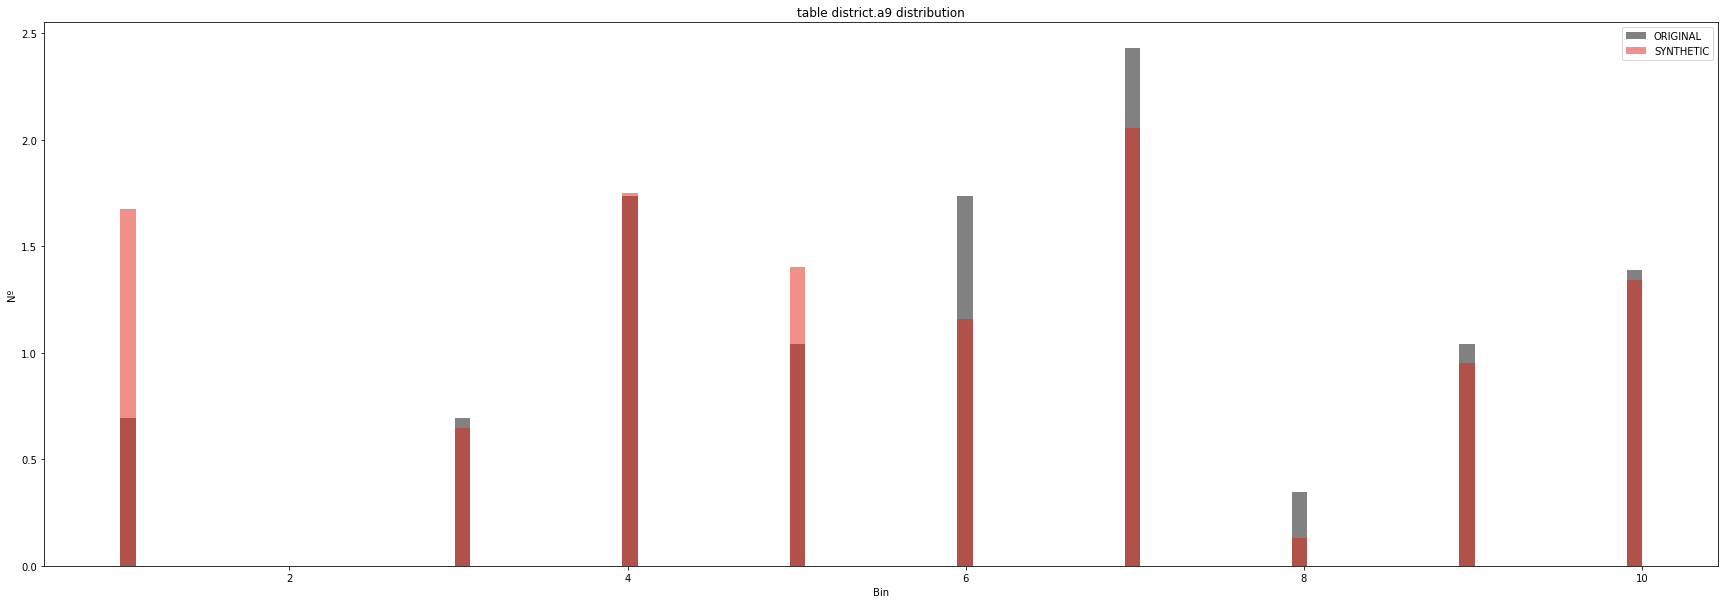

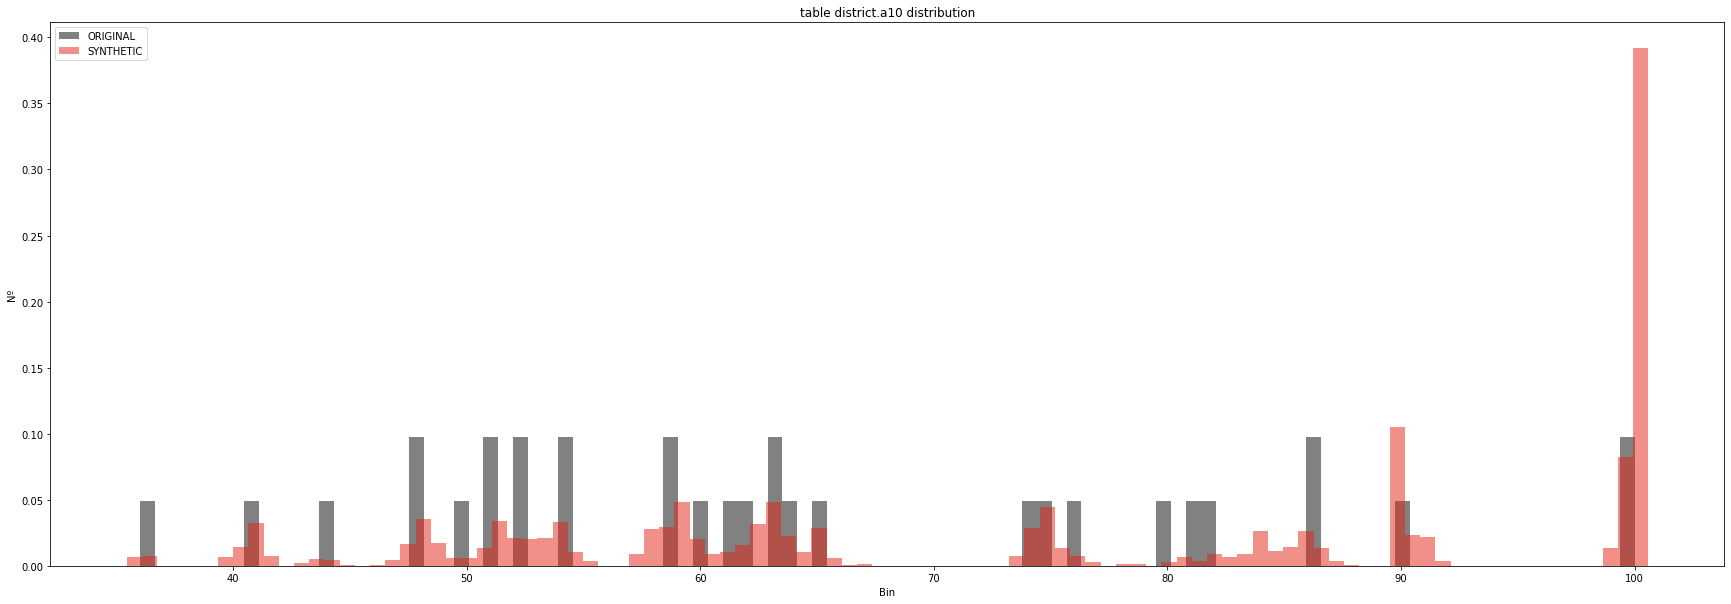

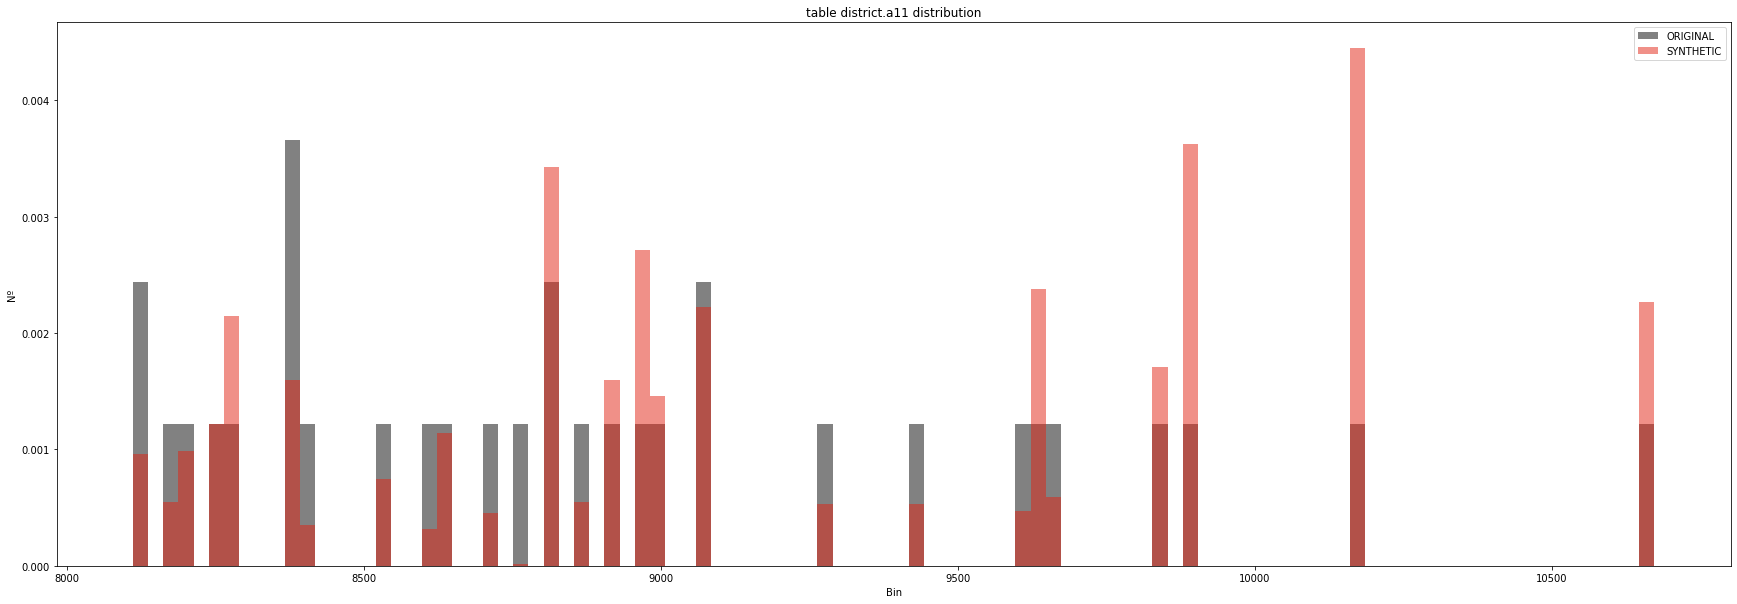

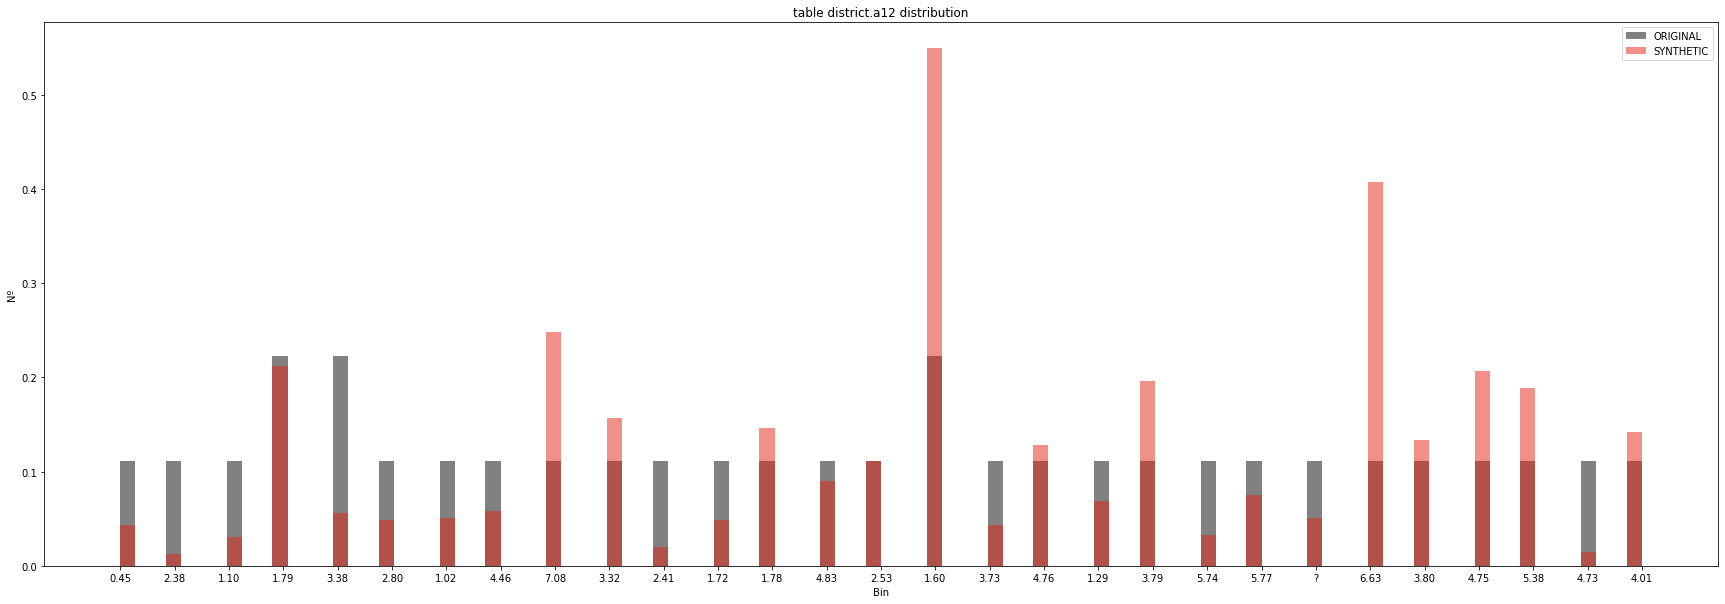

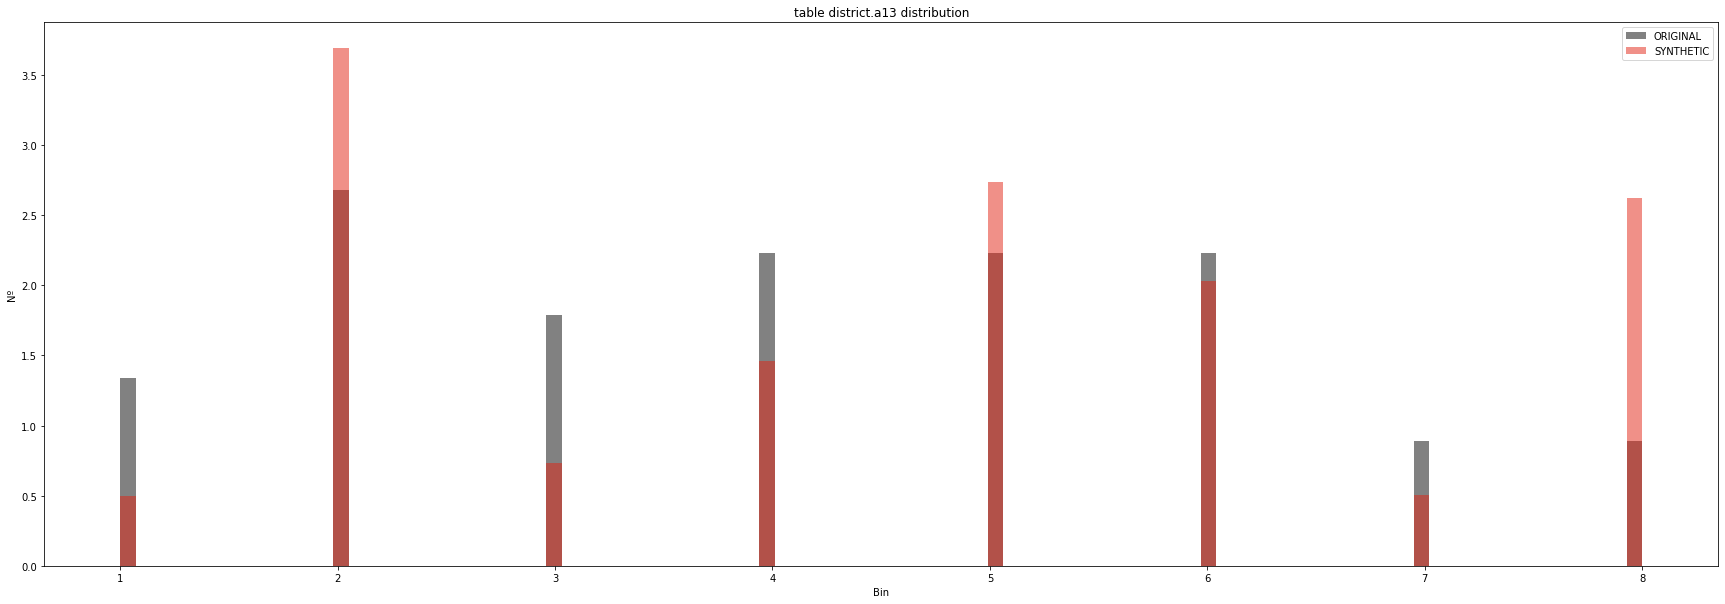

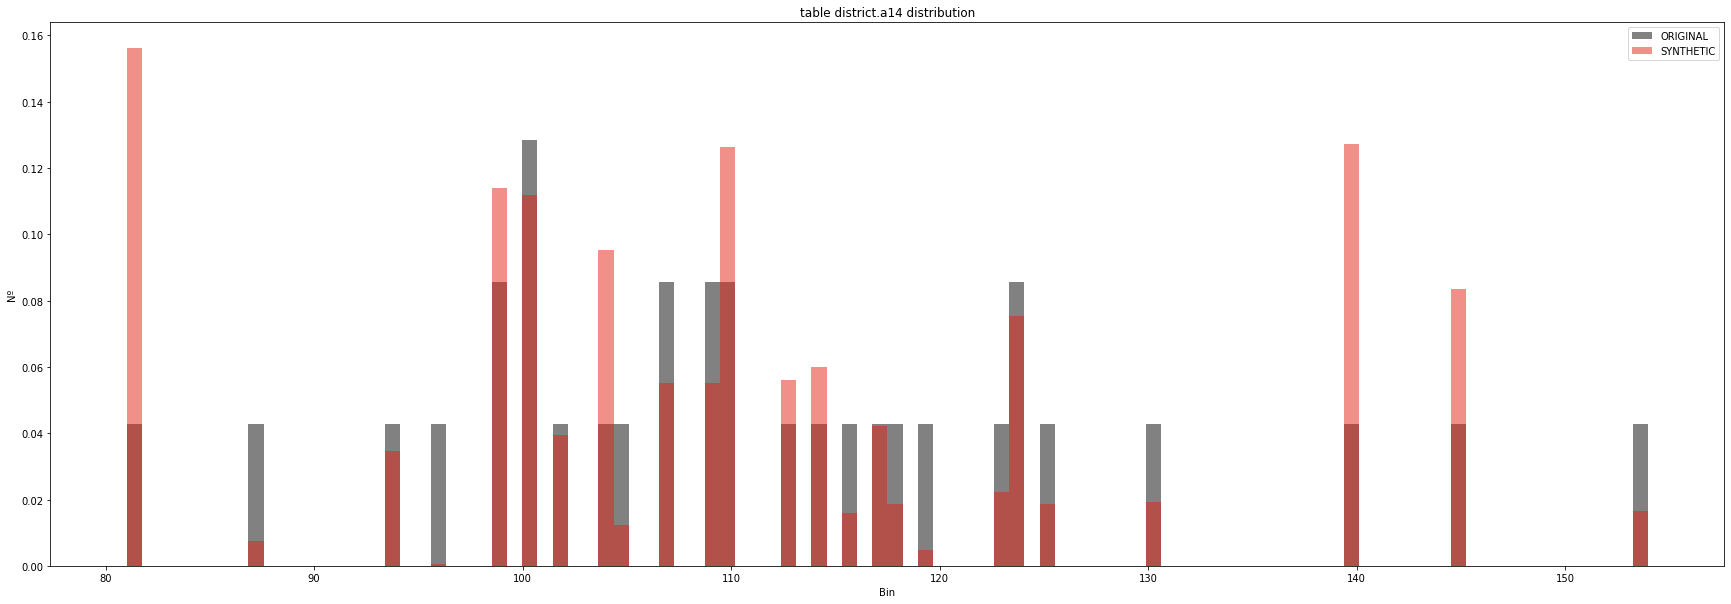

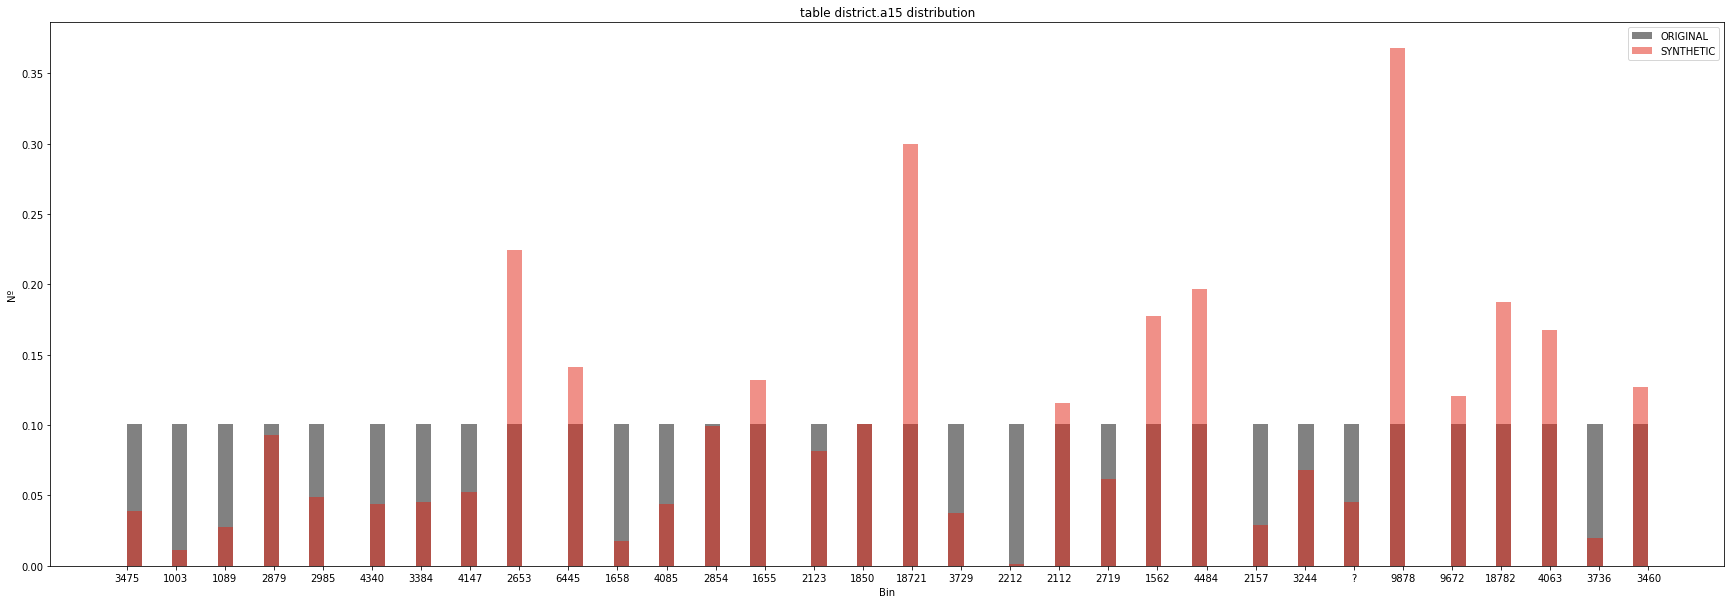

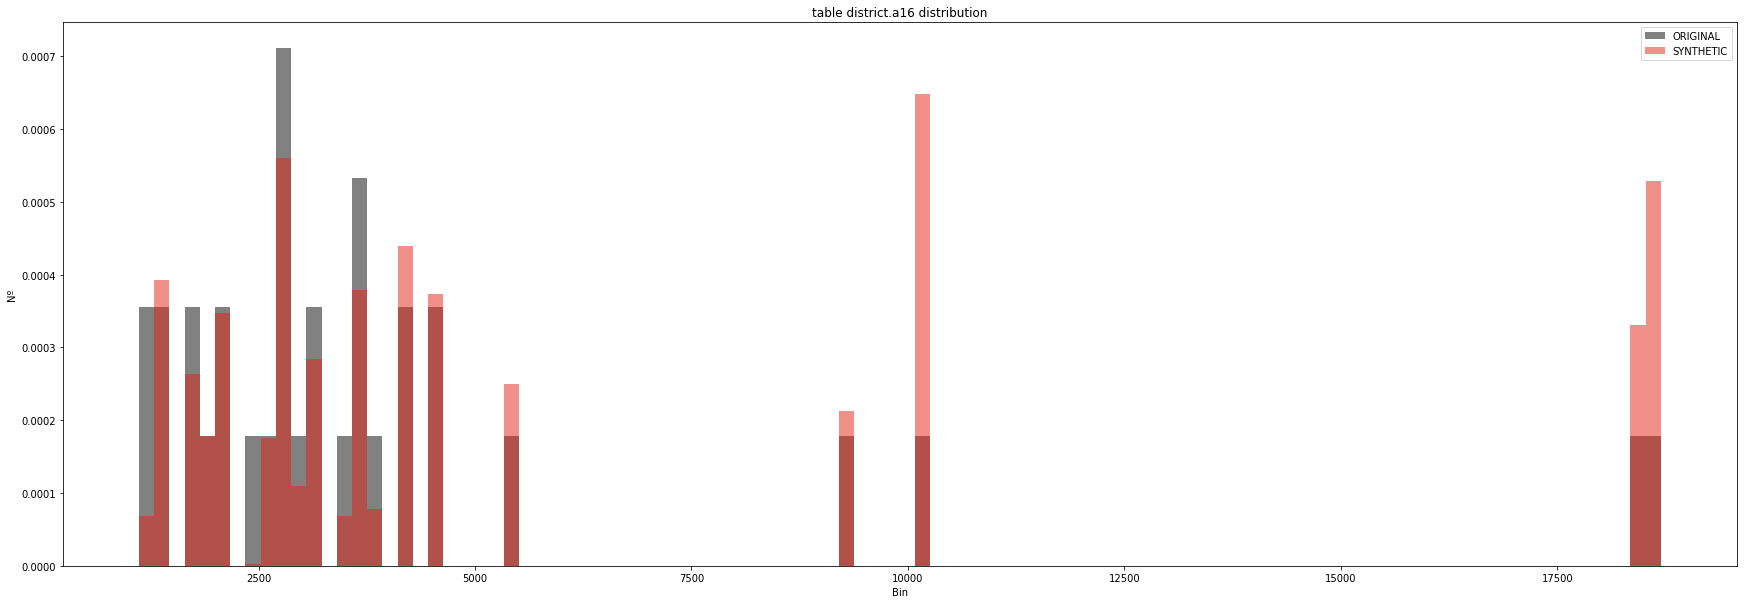

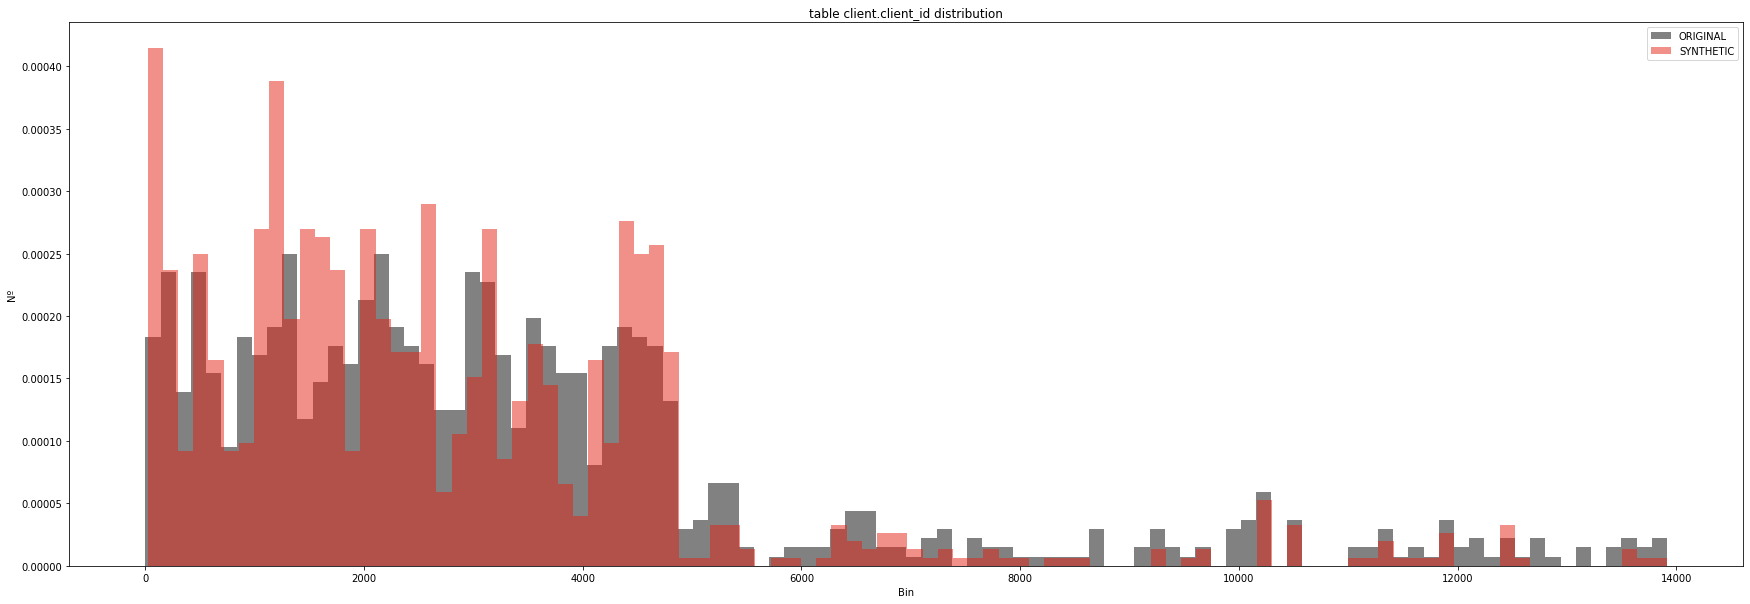

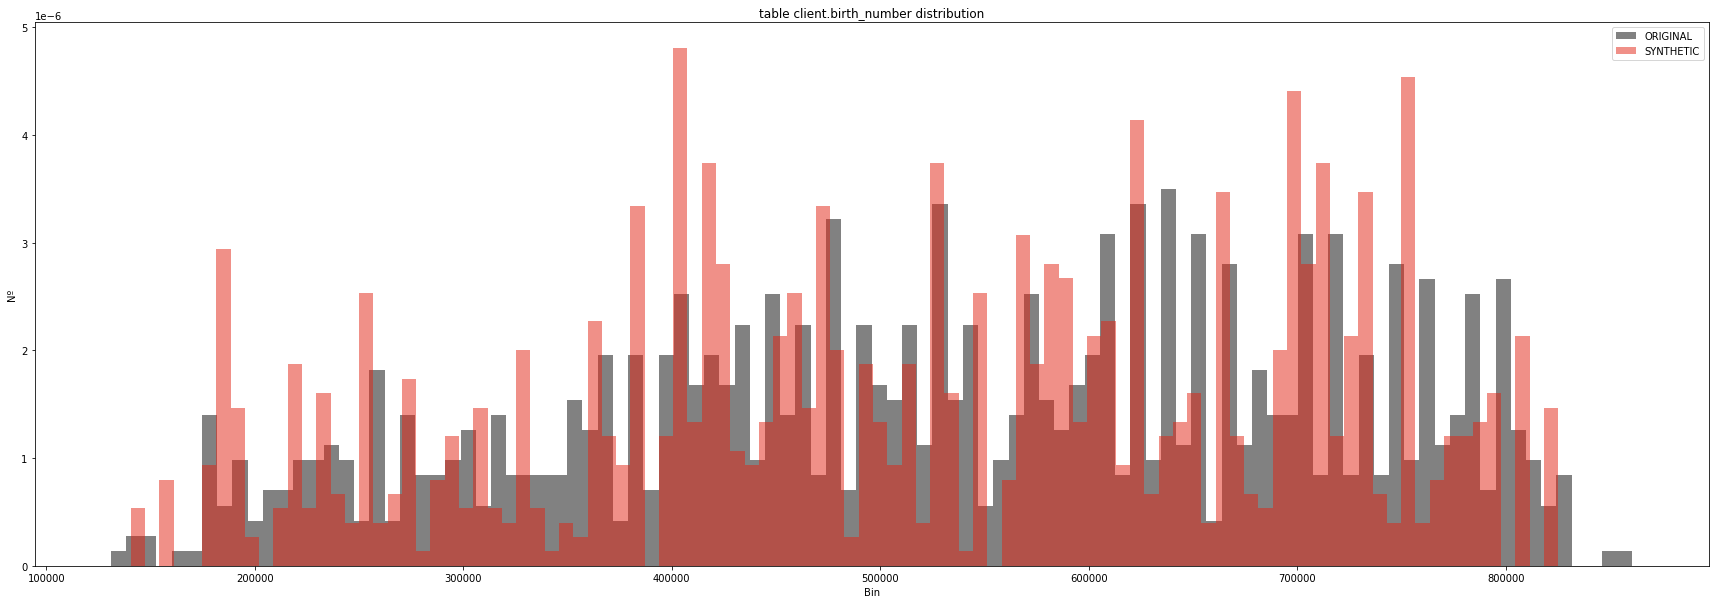

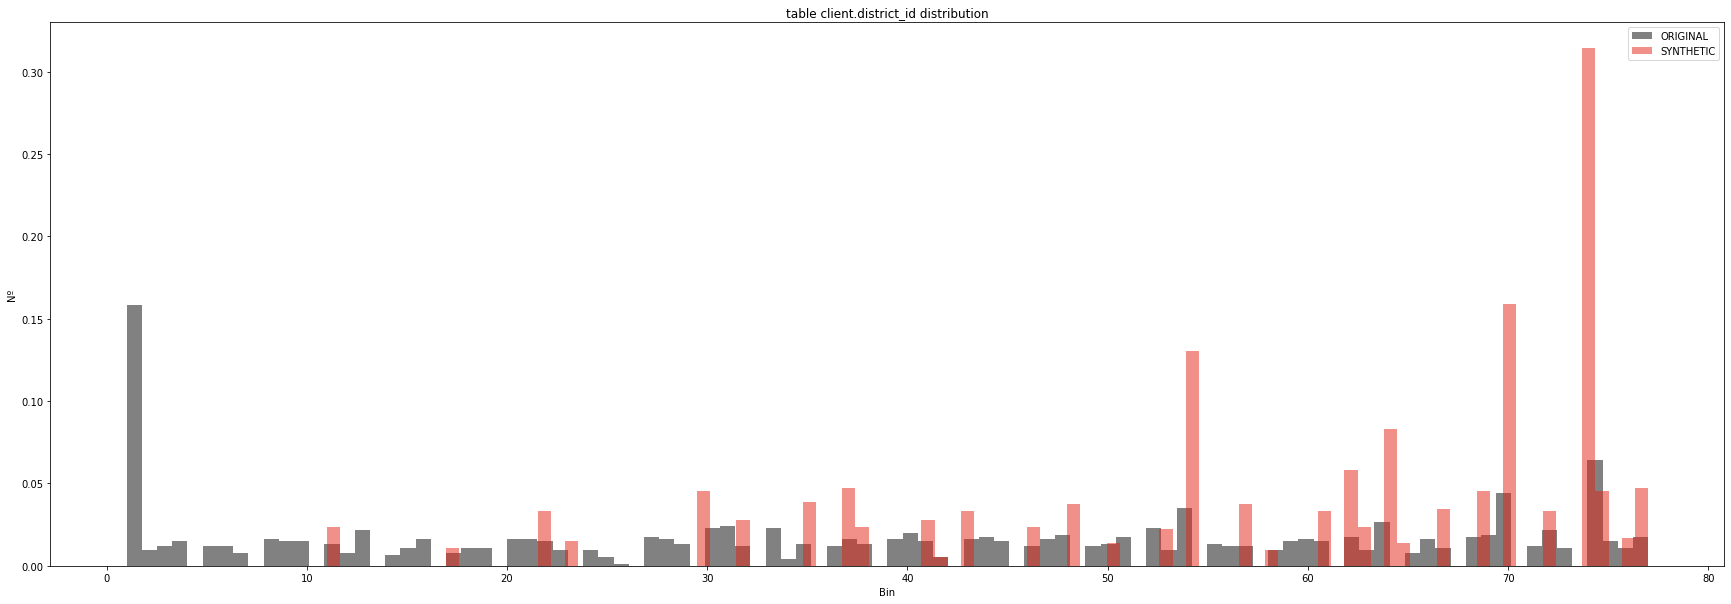

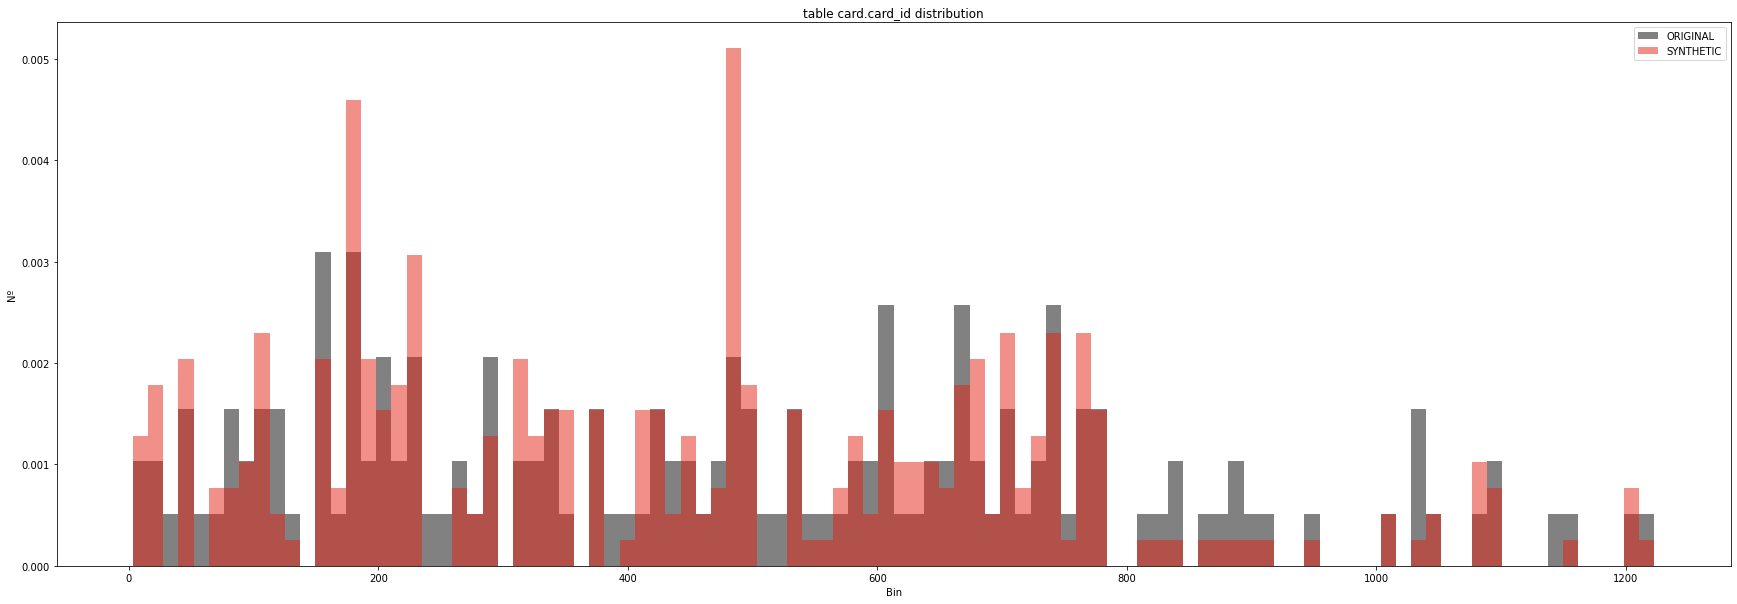

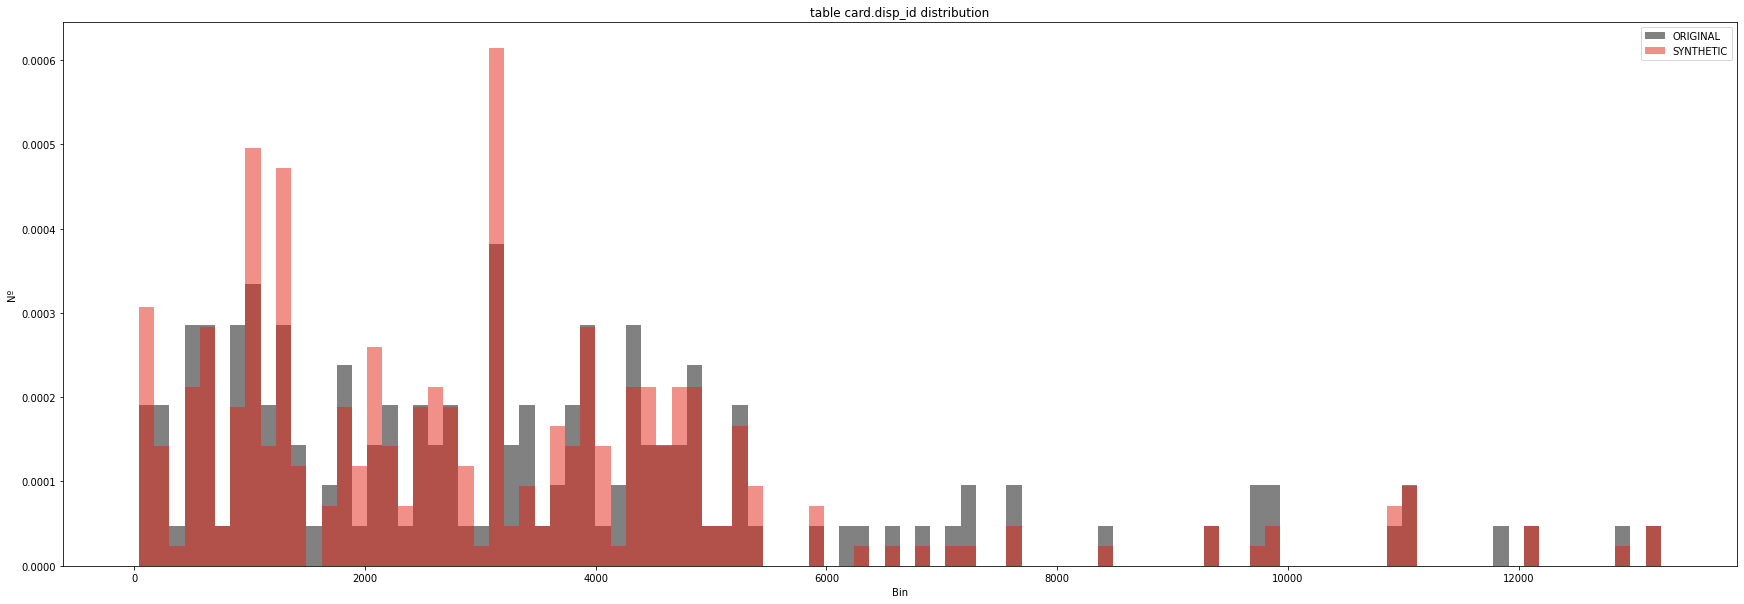

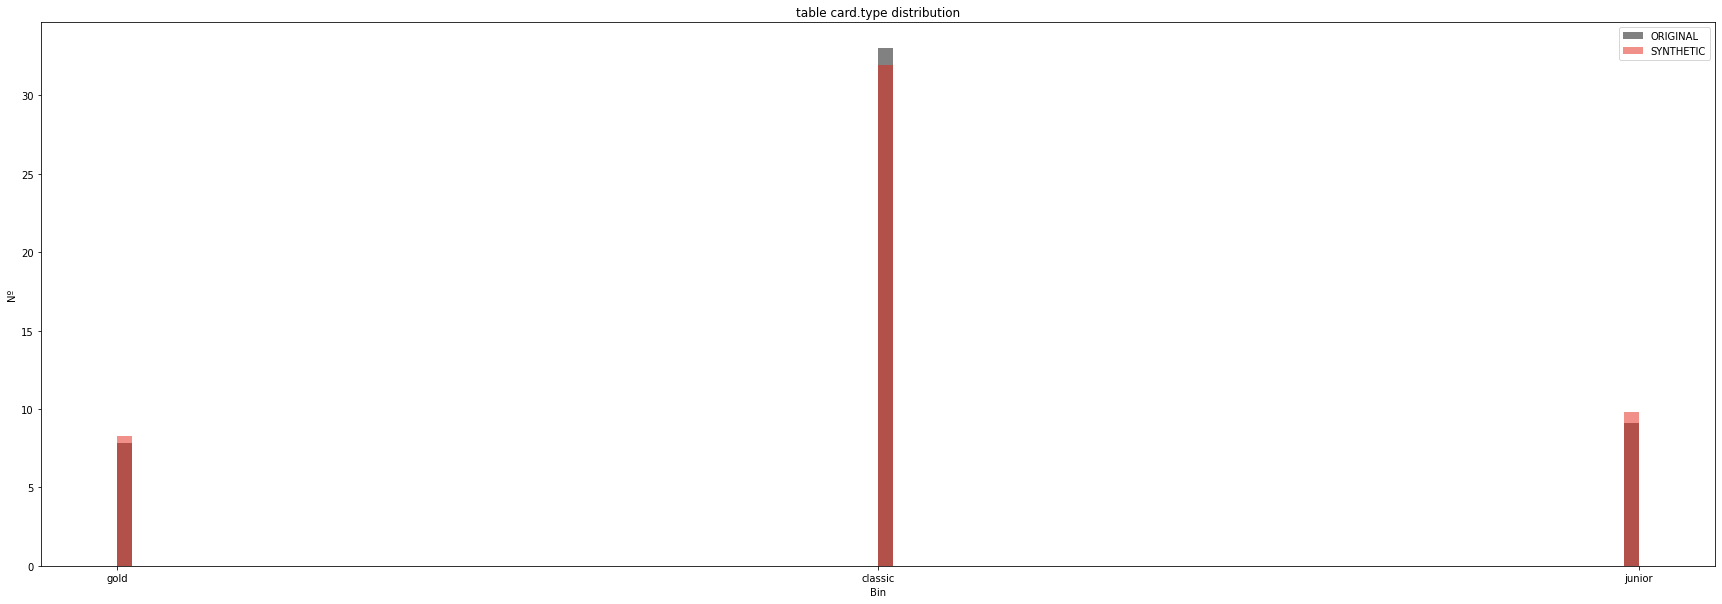

INFO: 2022-07-15 12:15:49,426 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2022-07-15 12:15:49,461 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2022-07-15 12:15:49,746 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


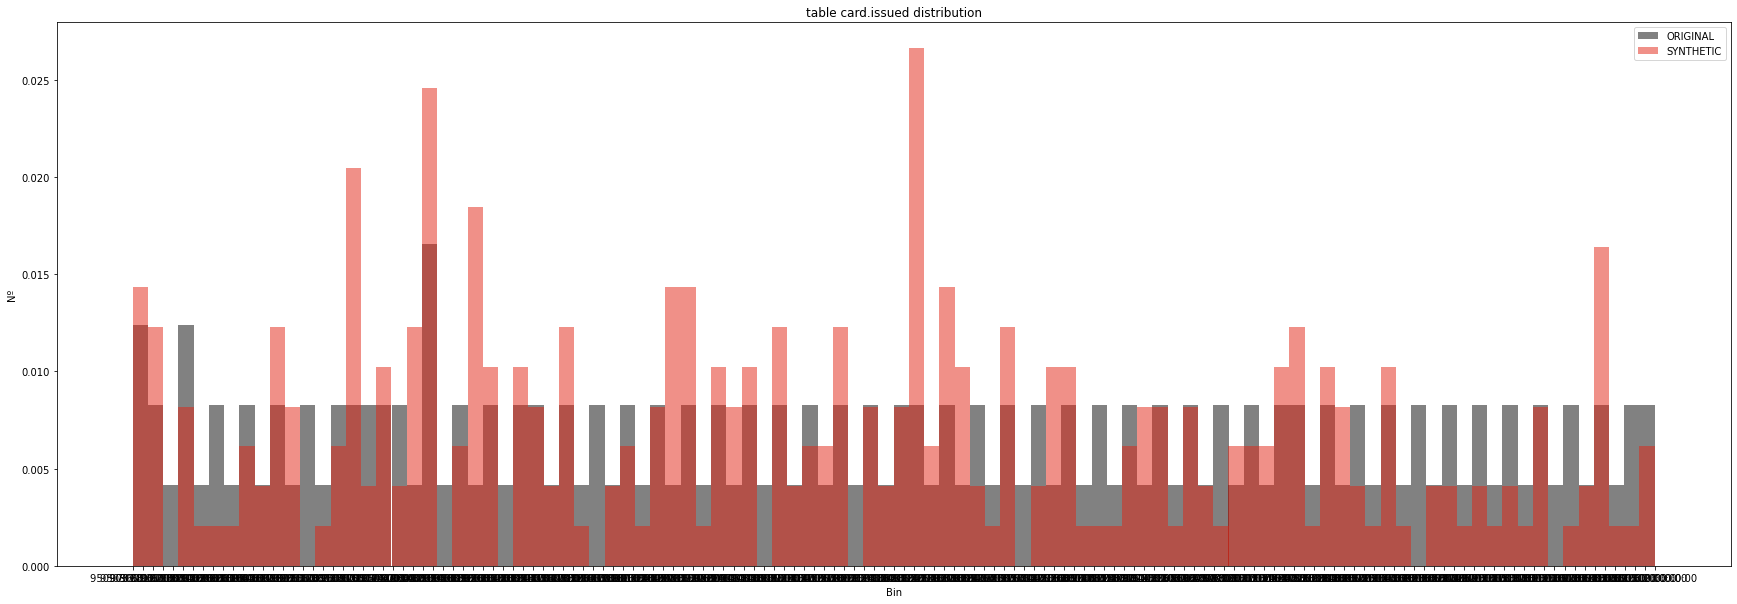

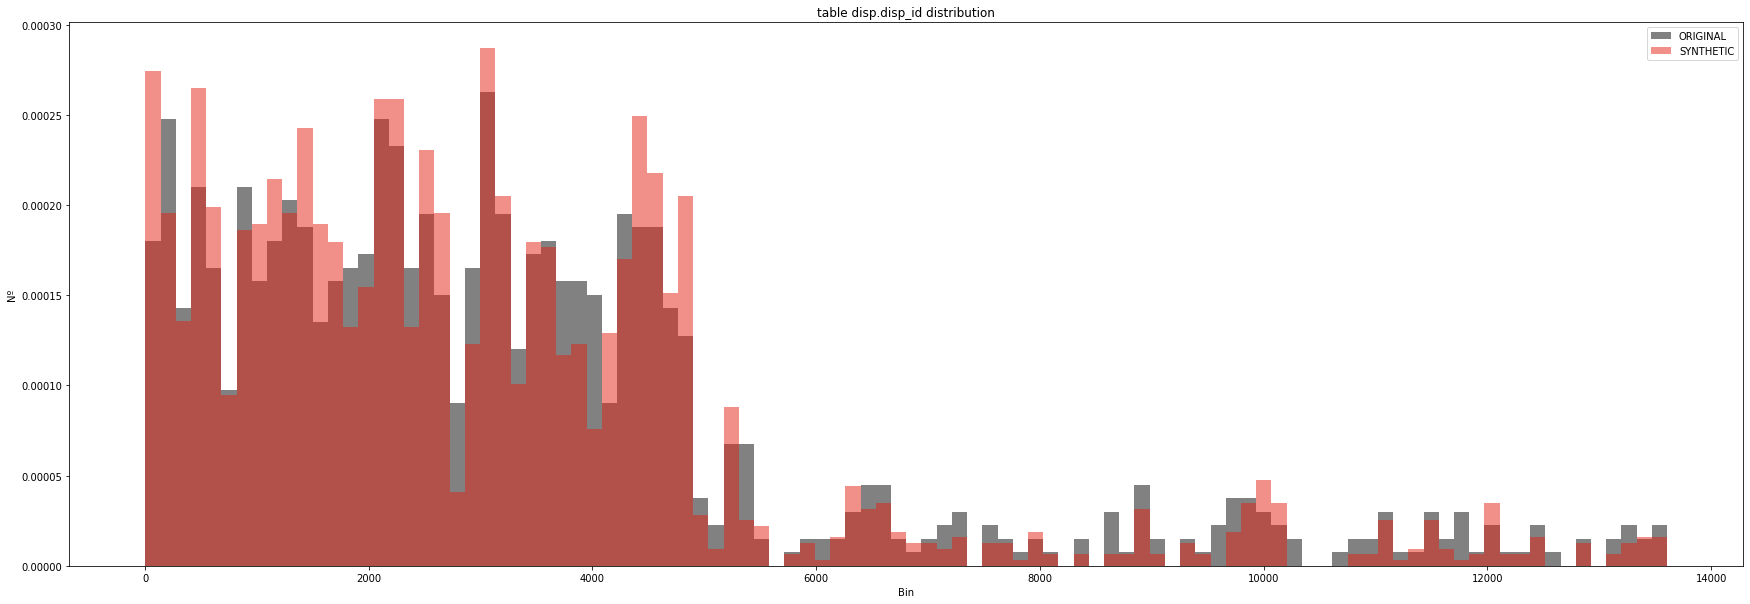

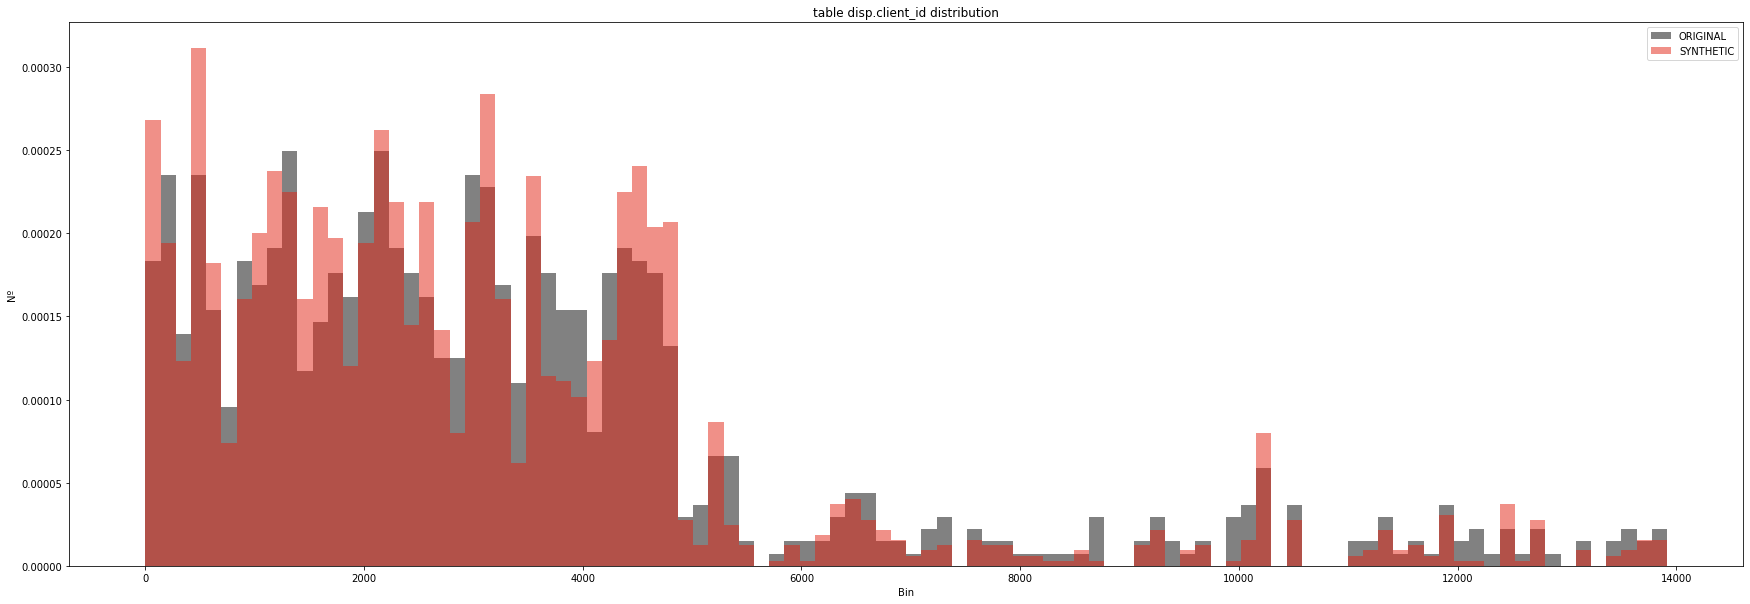

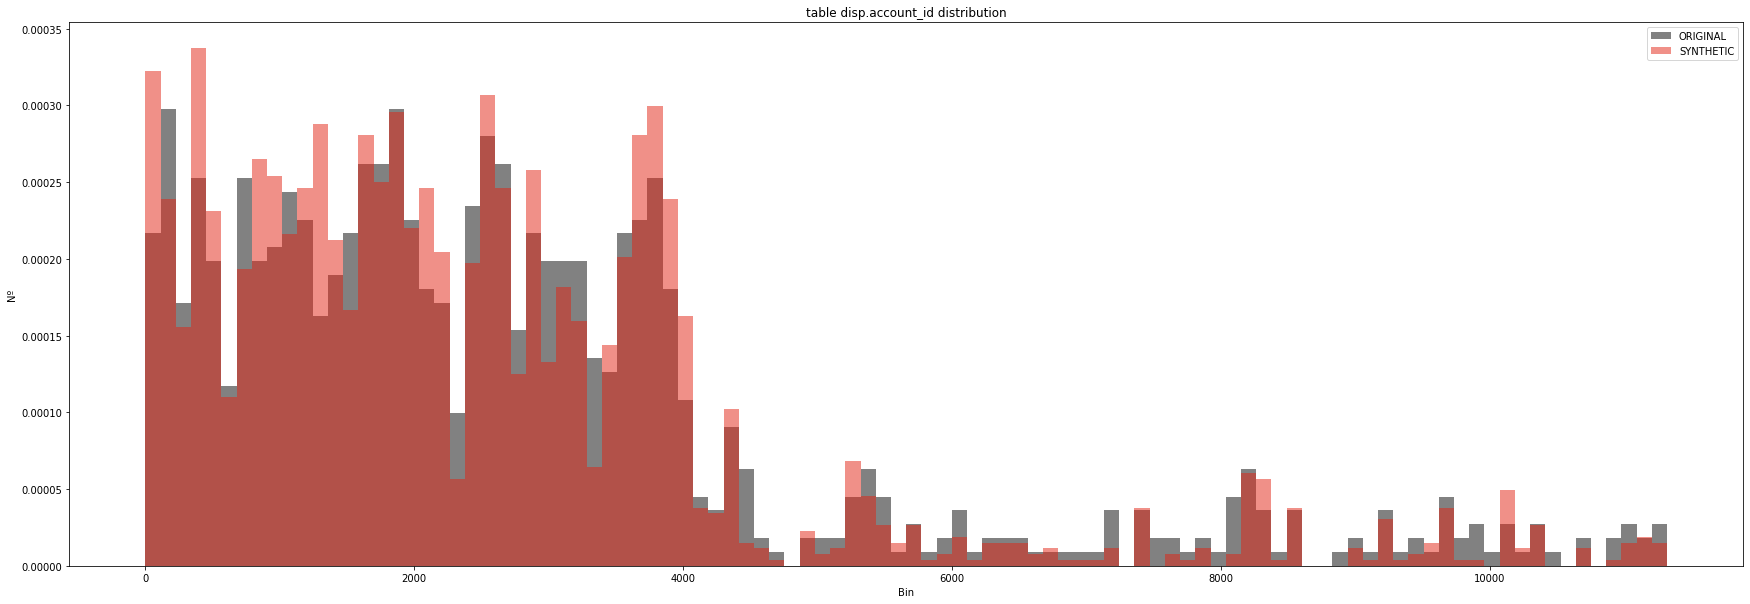

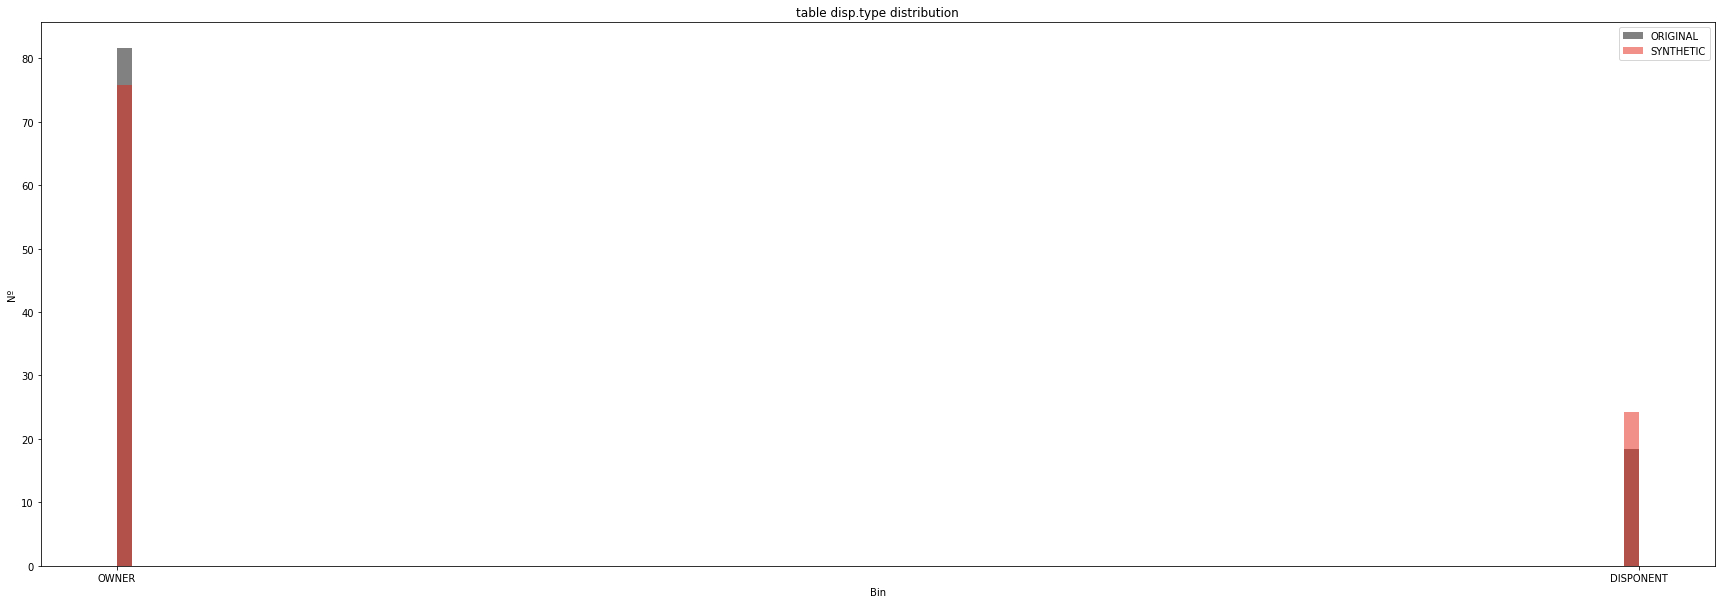

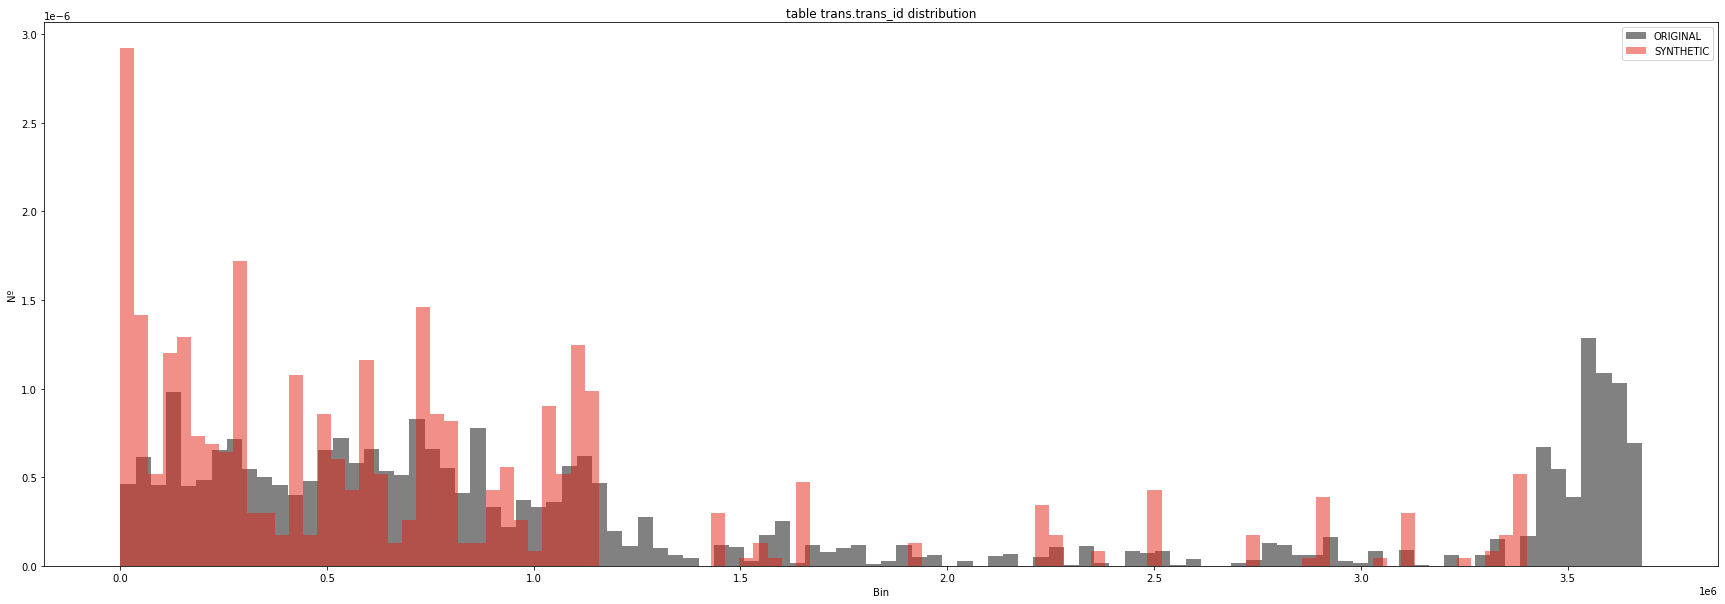

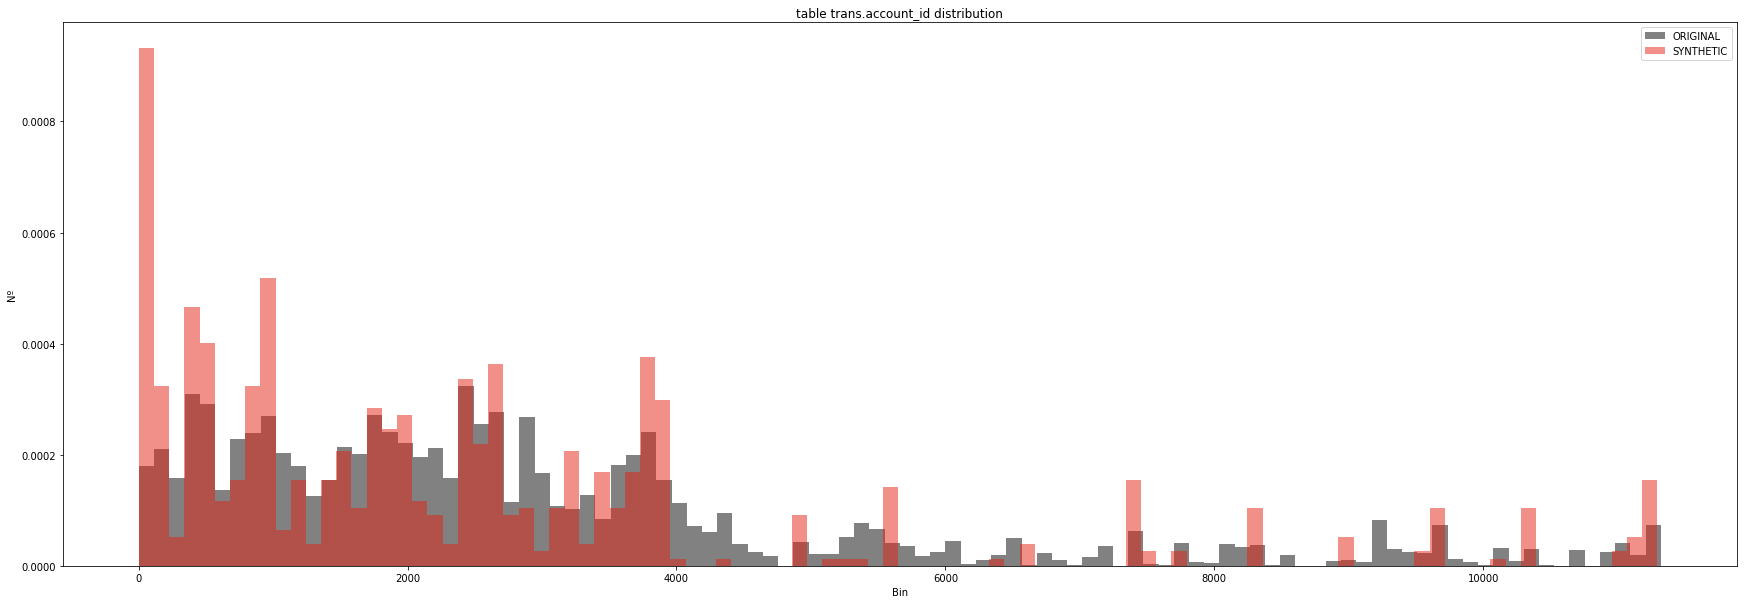

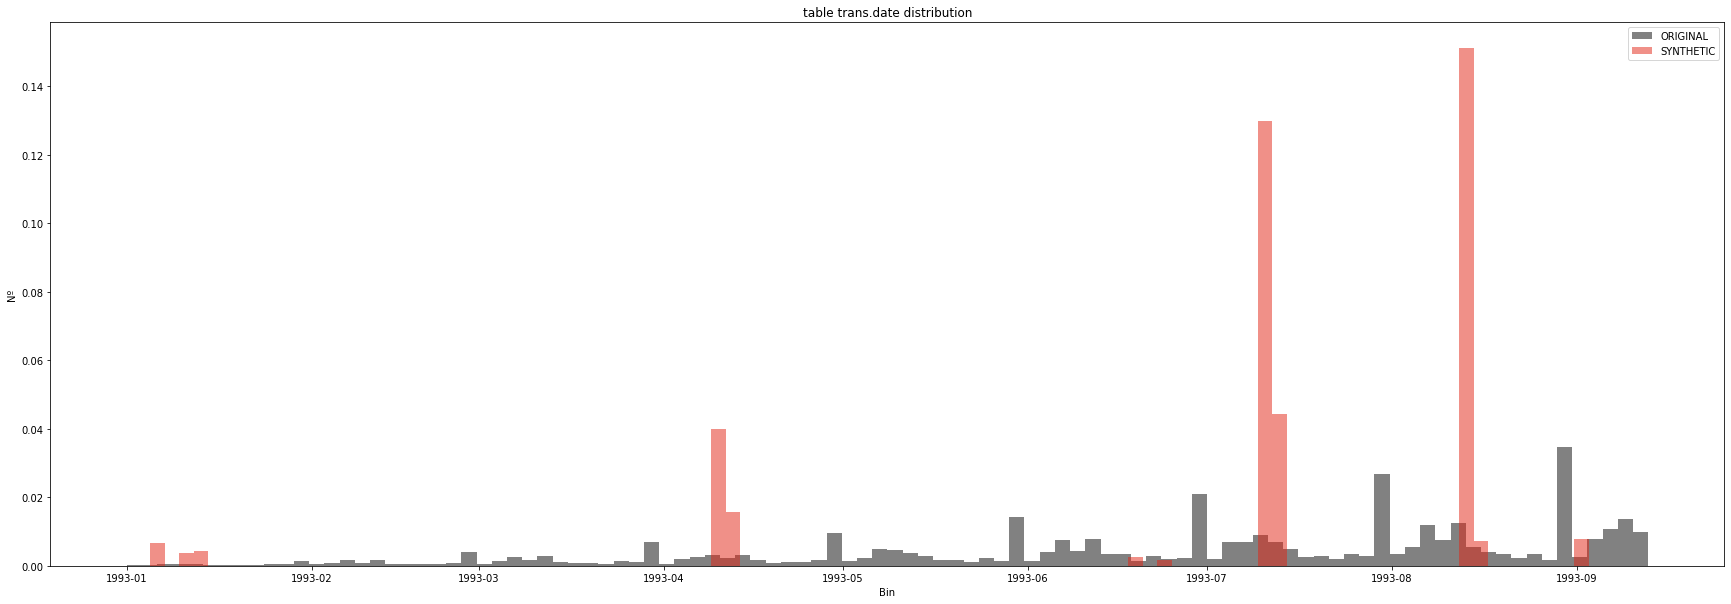

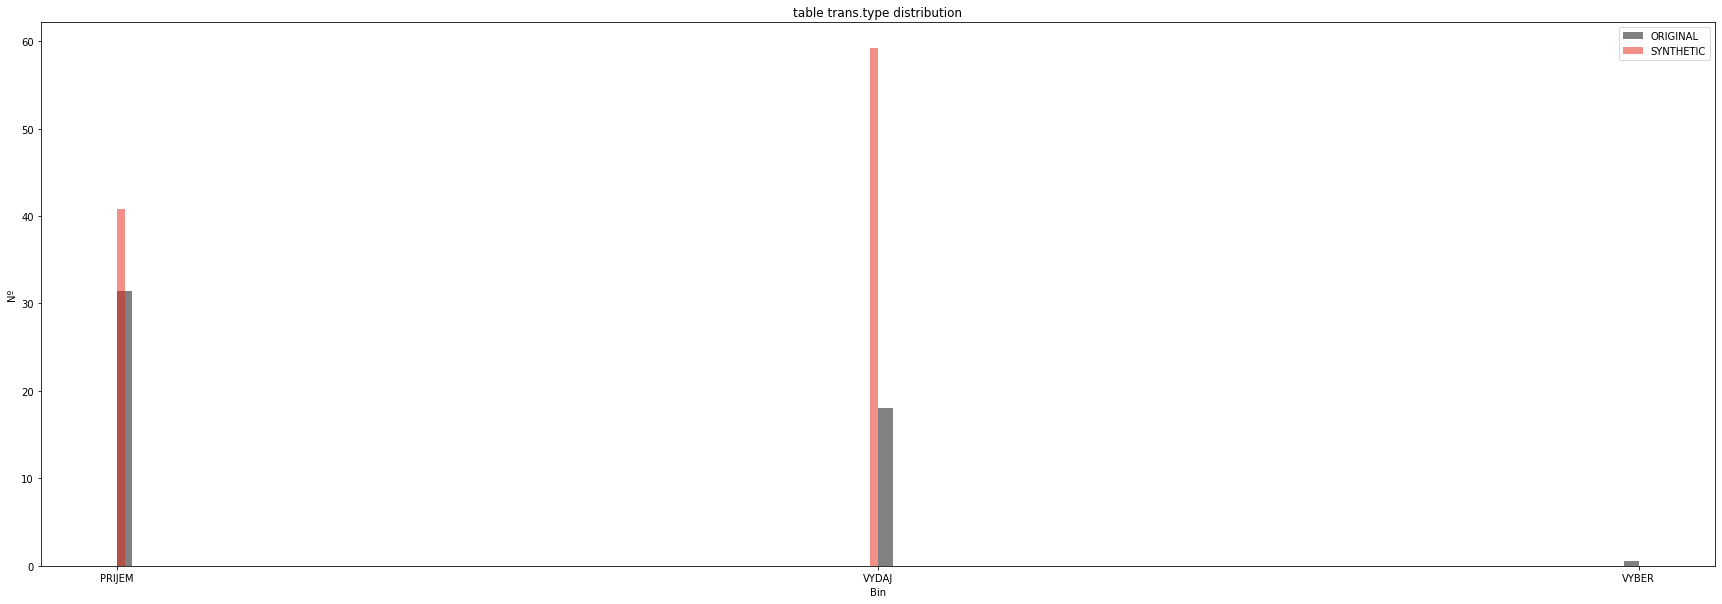

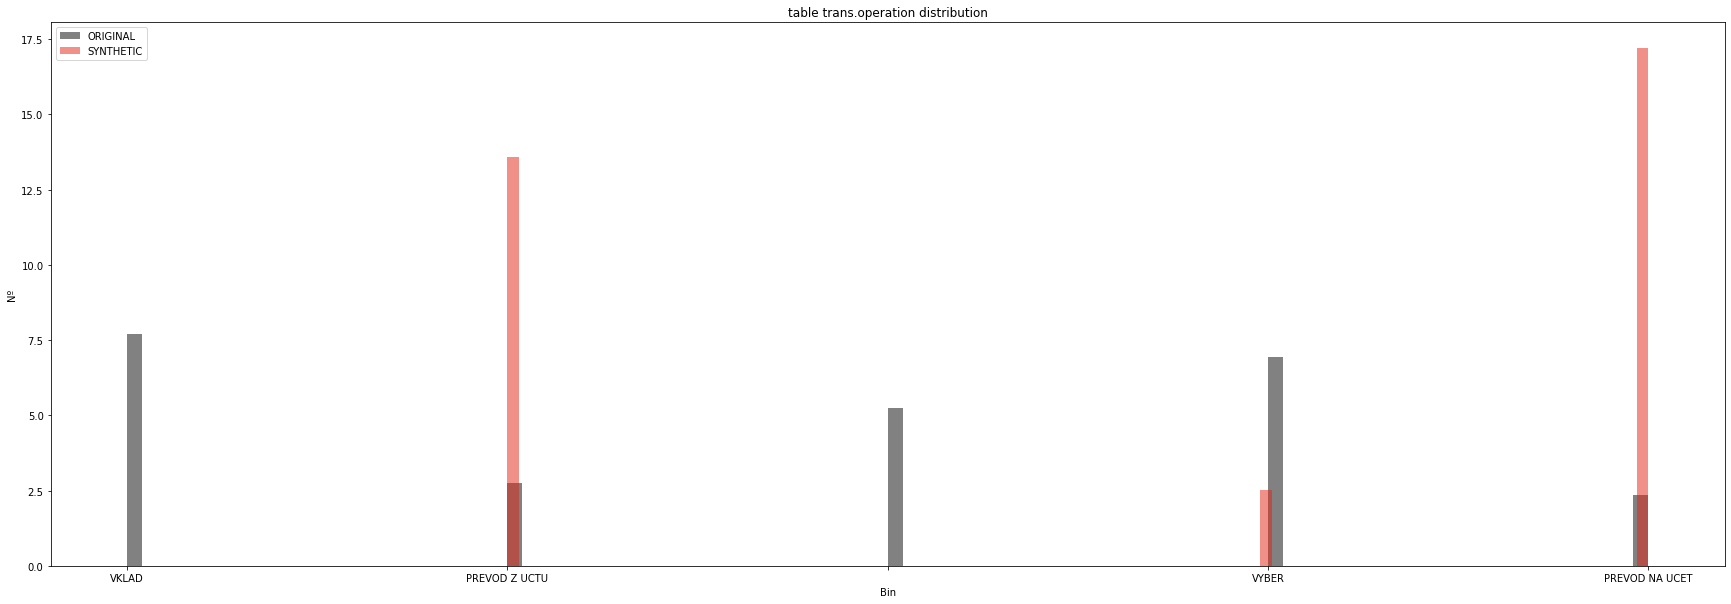

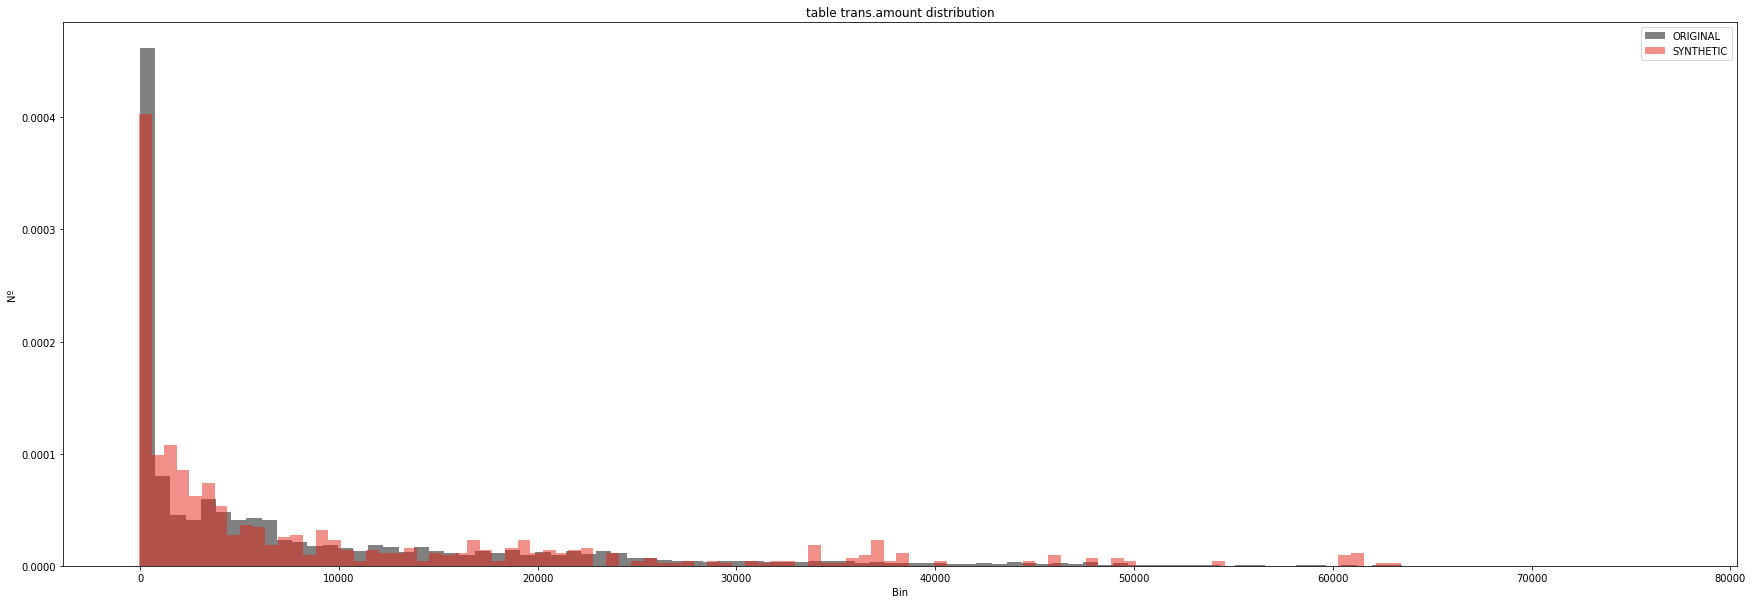

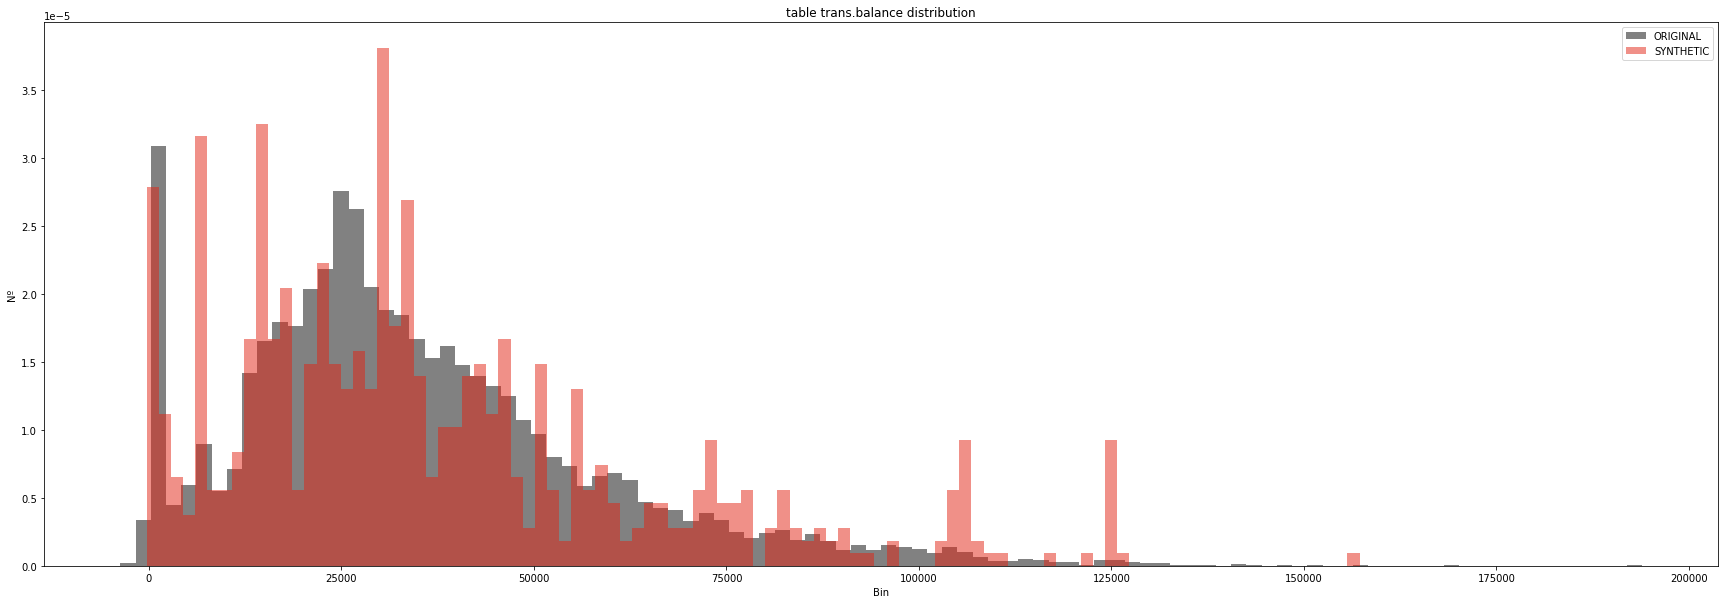

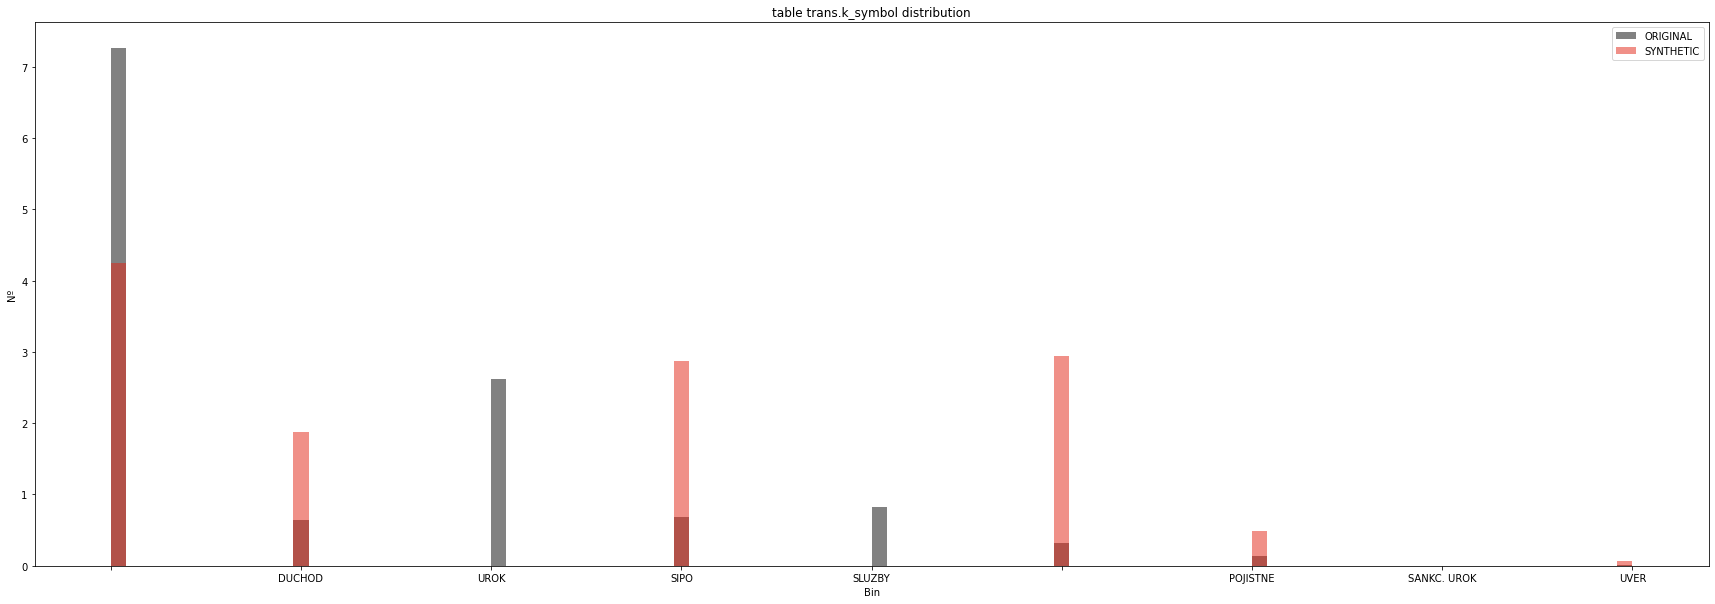

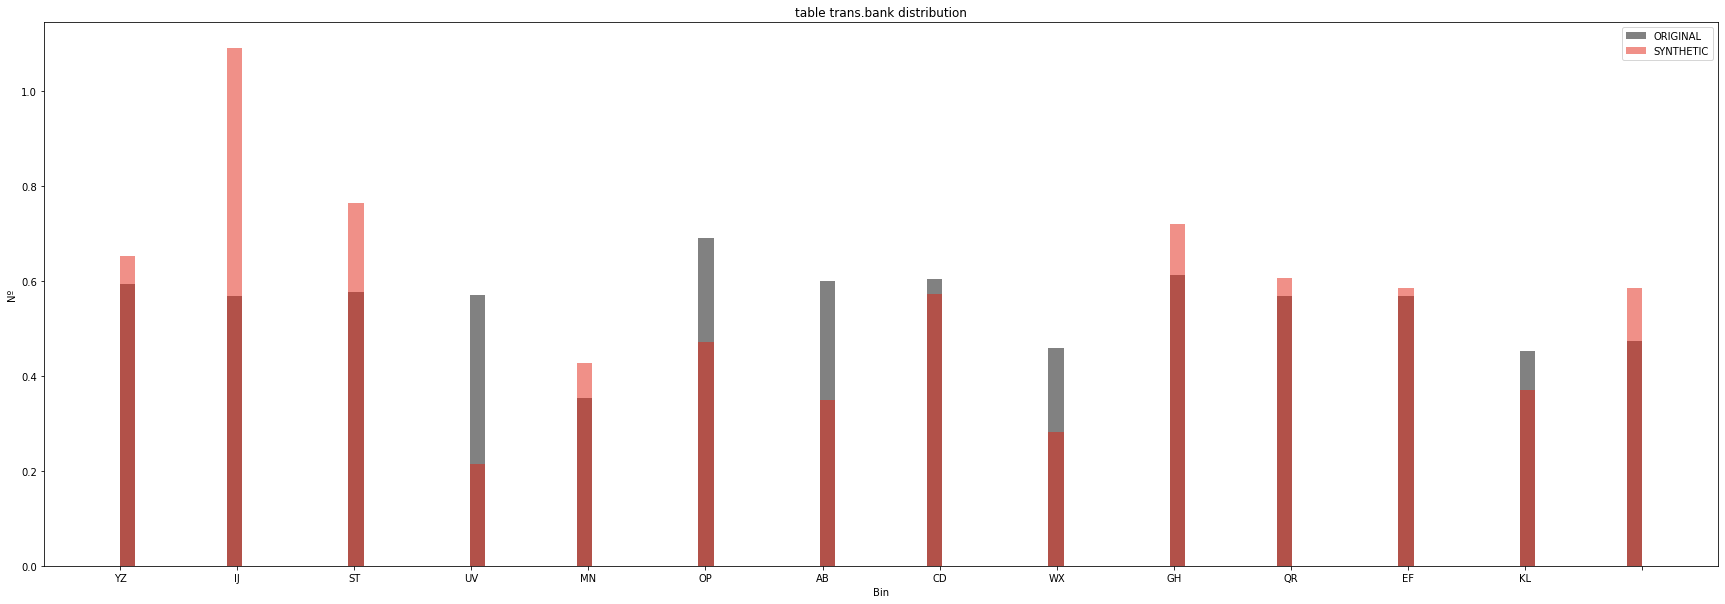

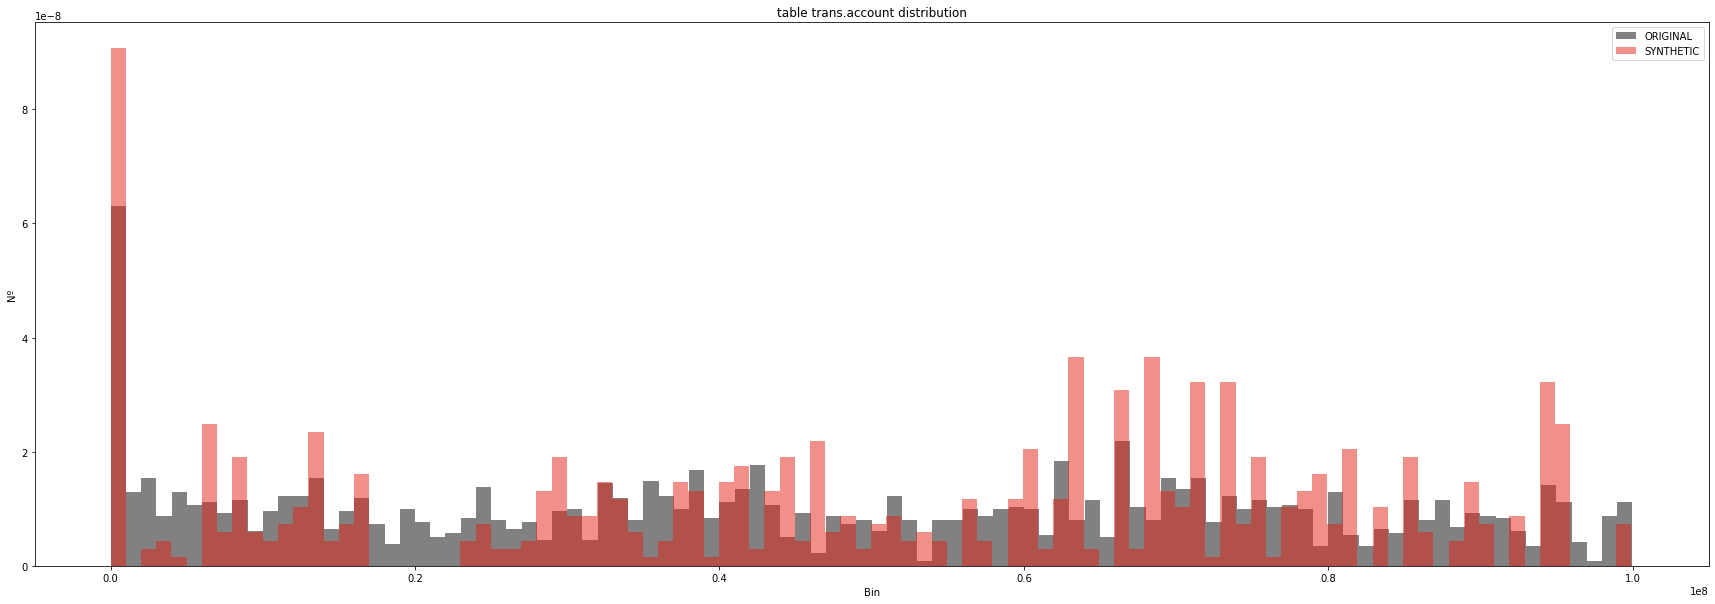

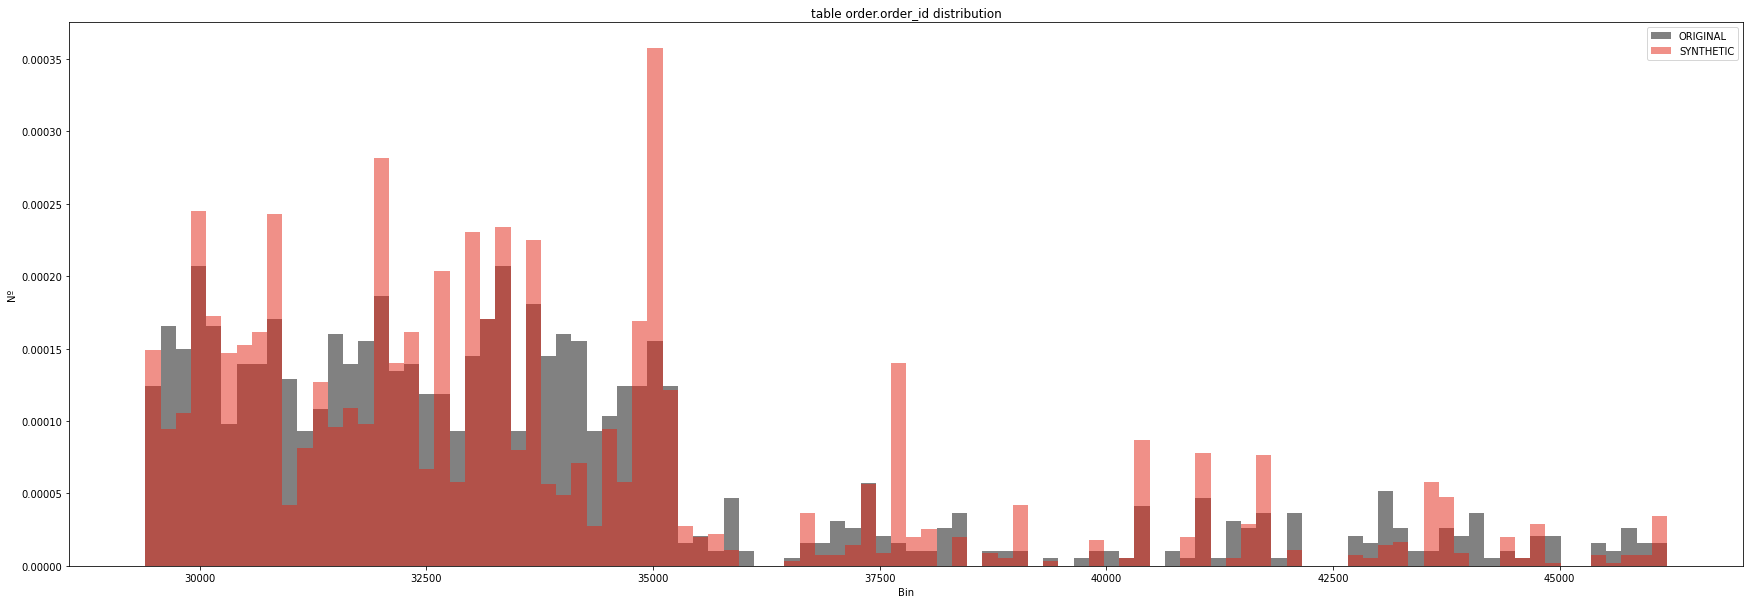

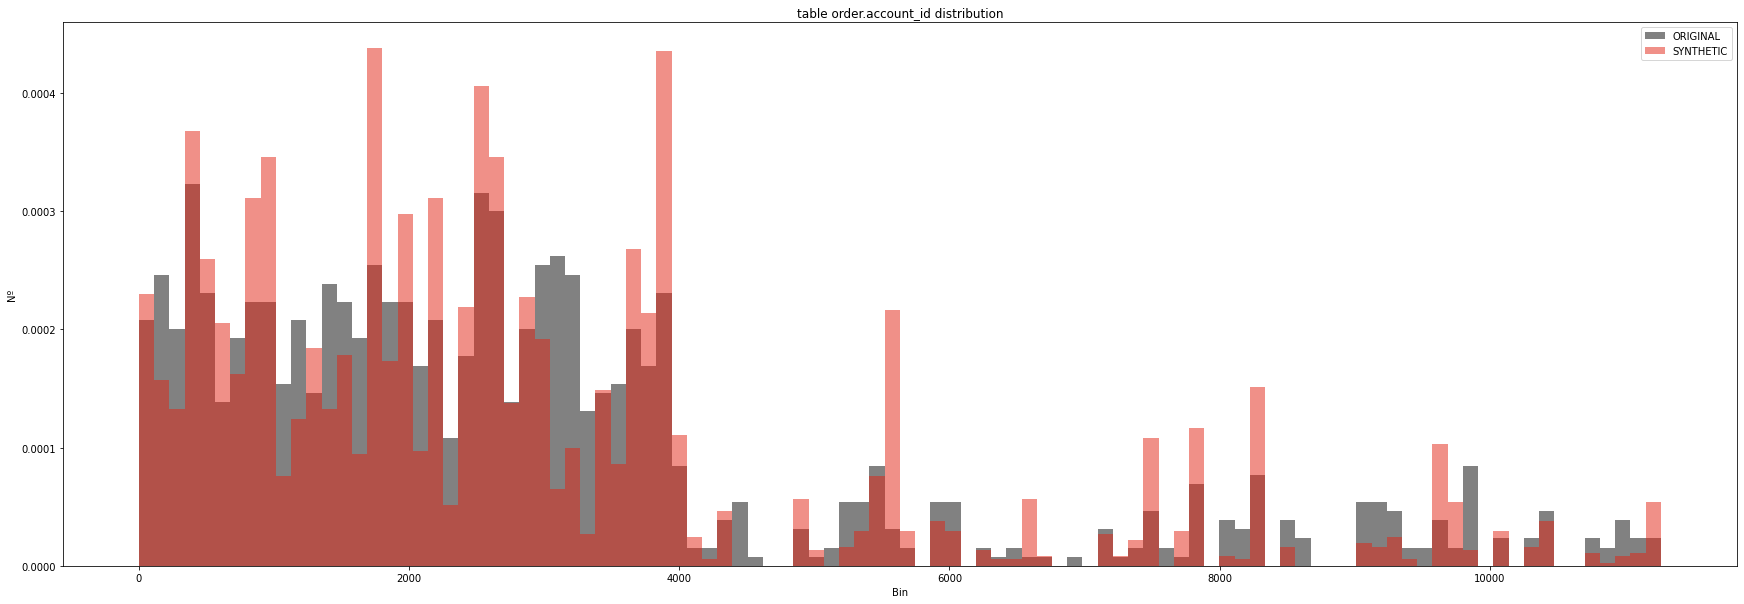

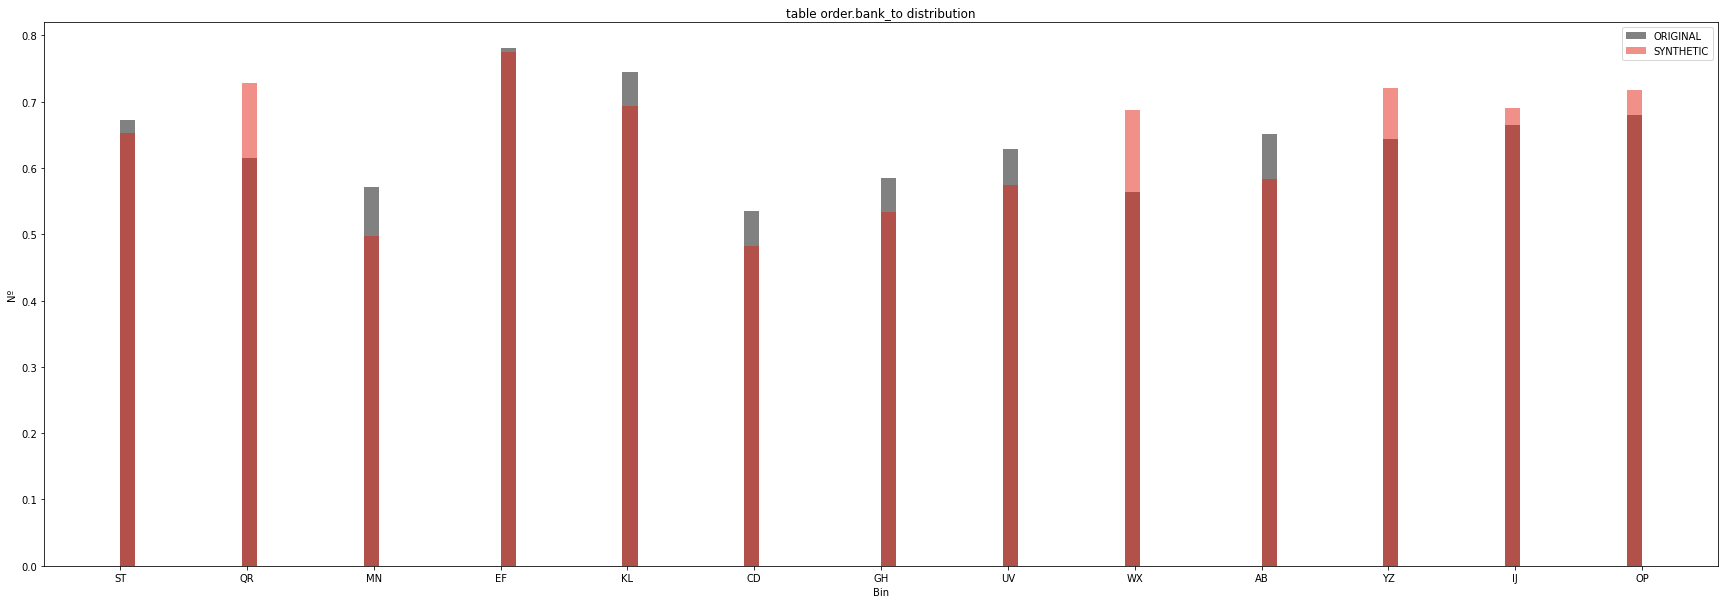

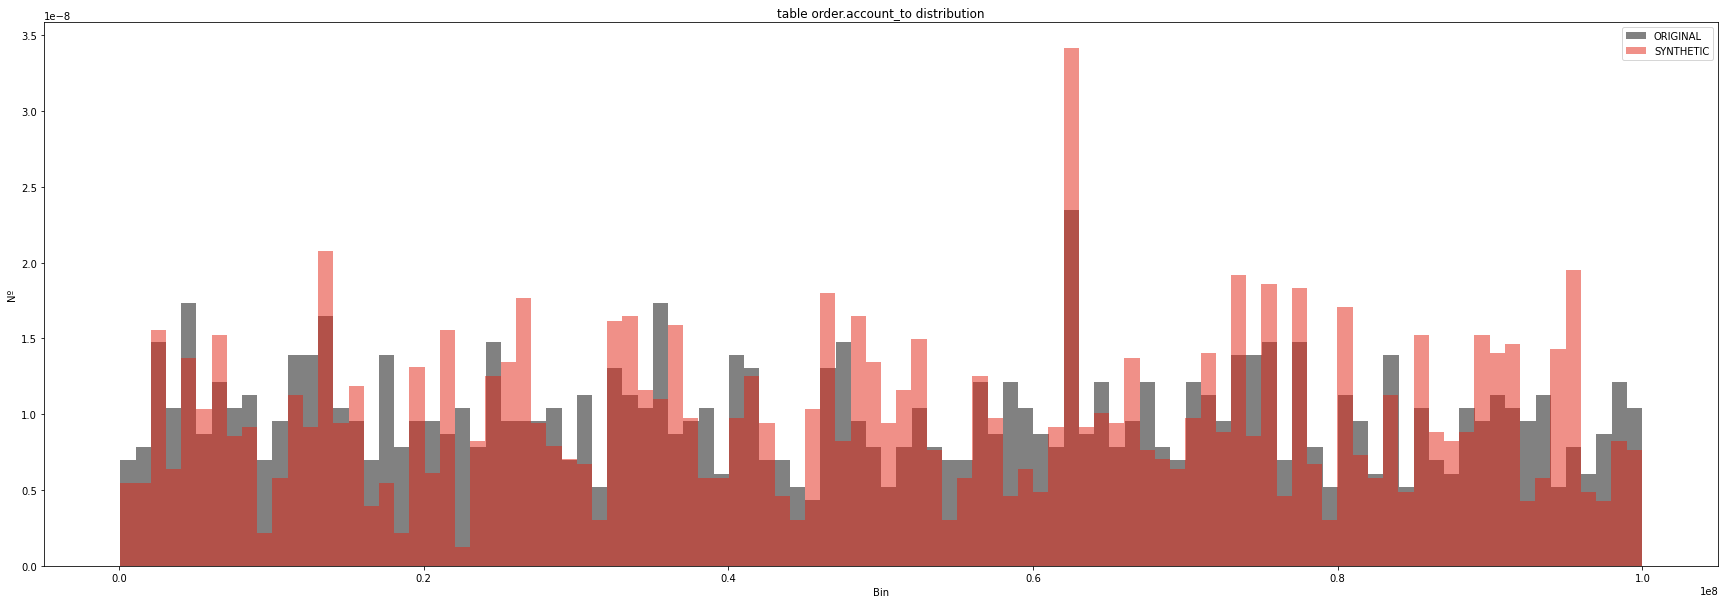

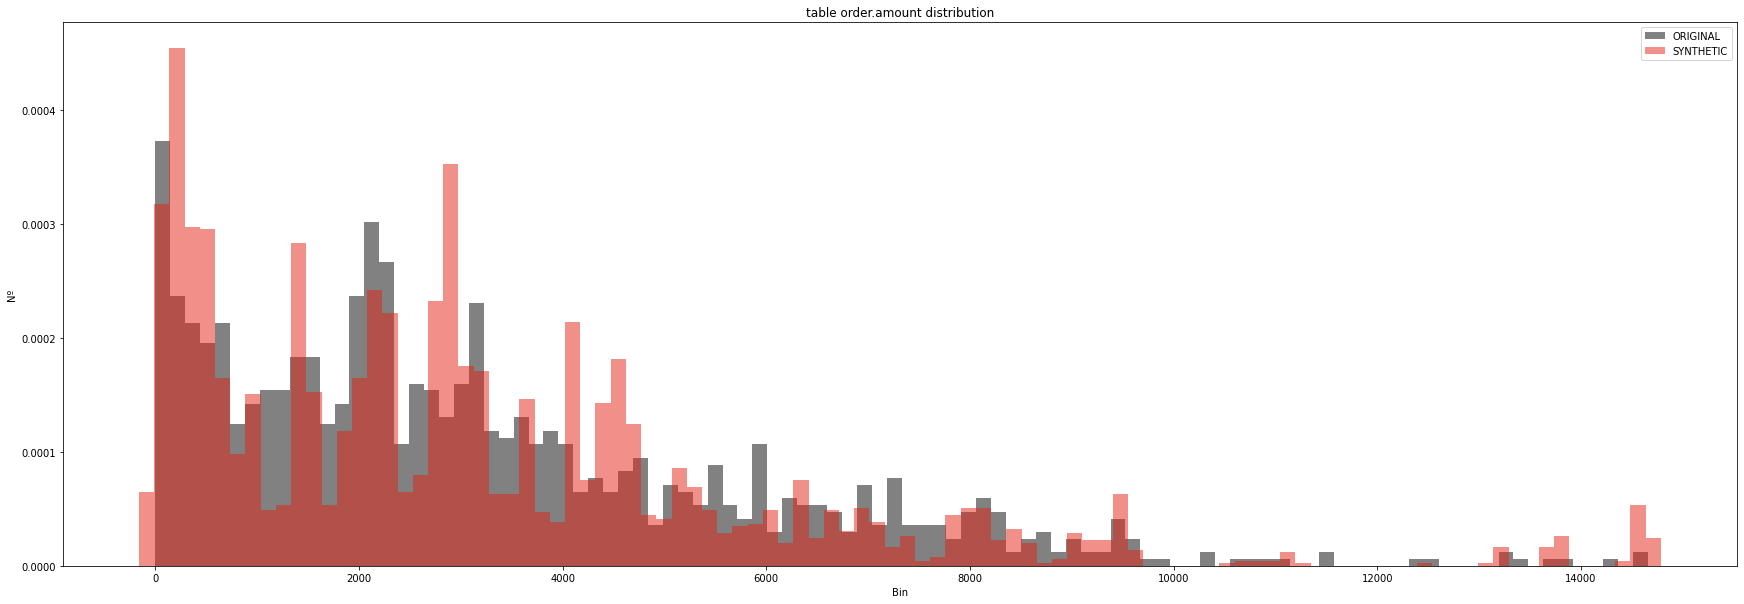

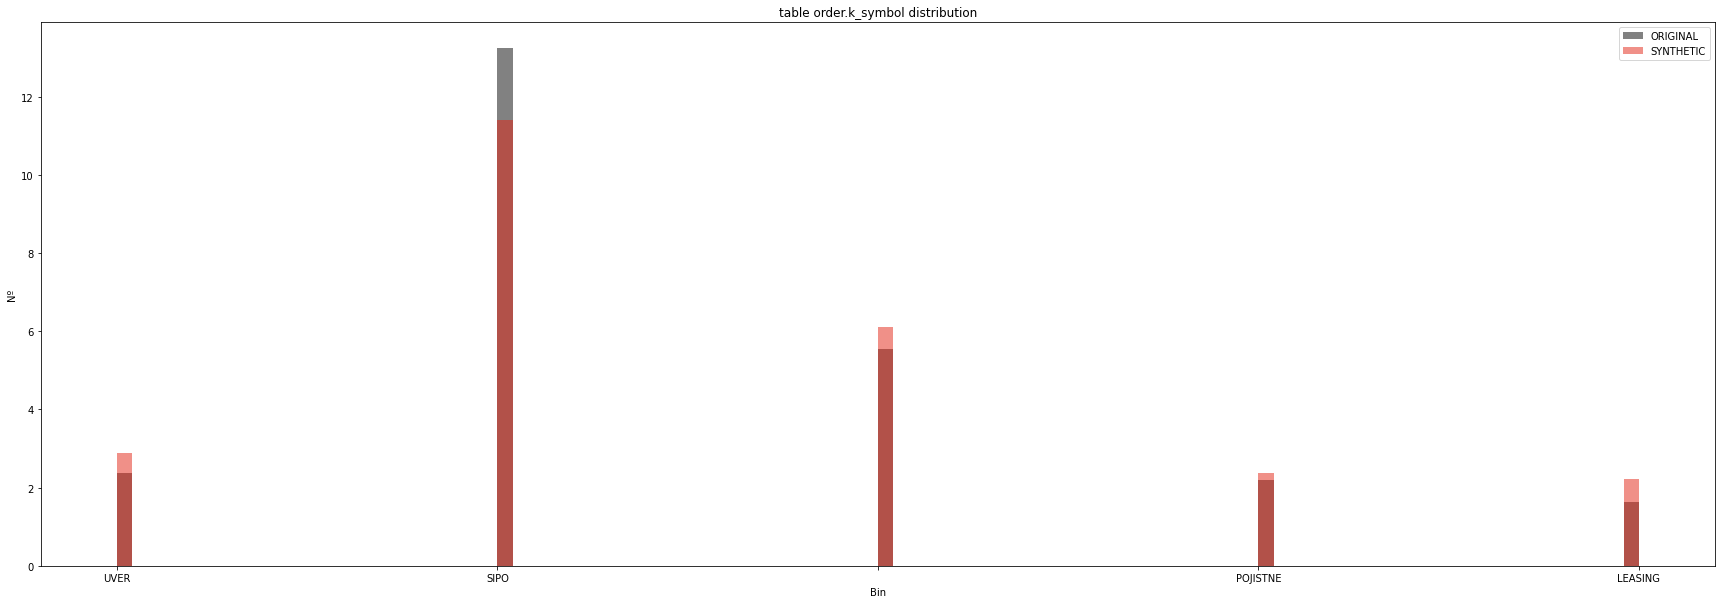

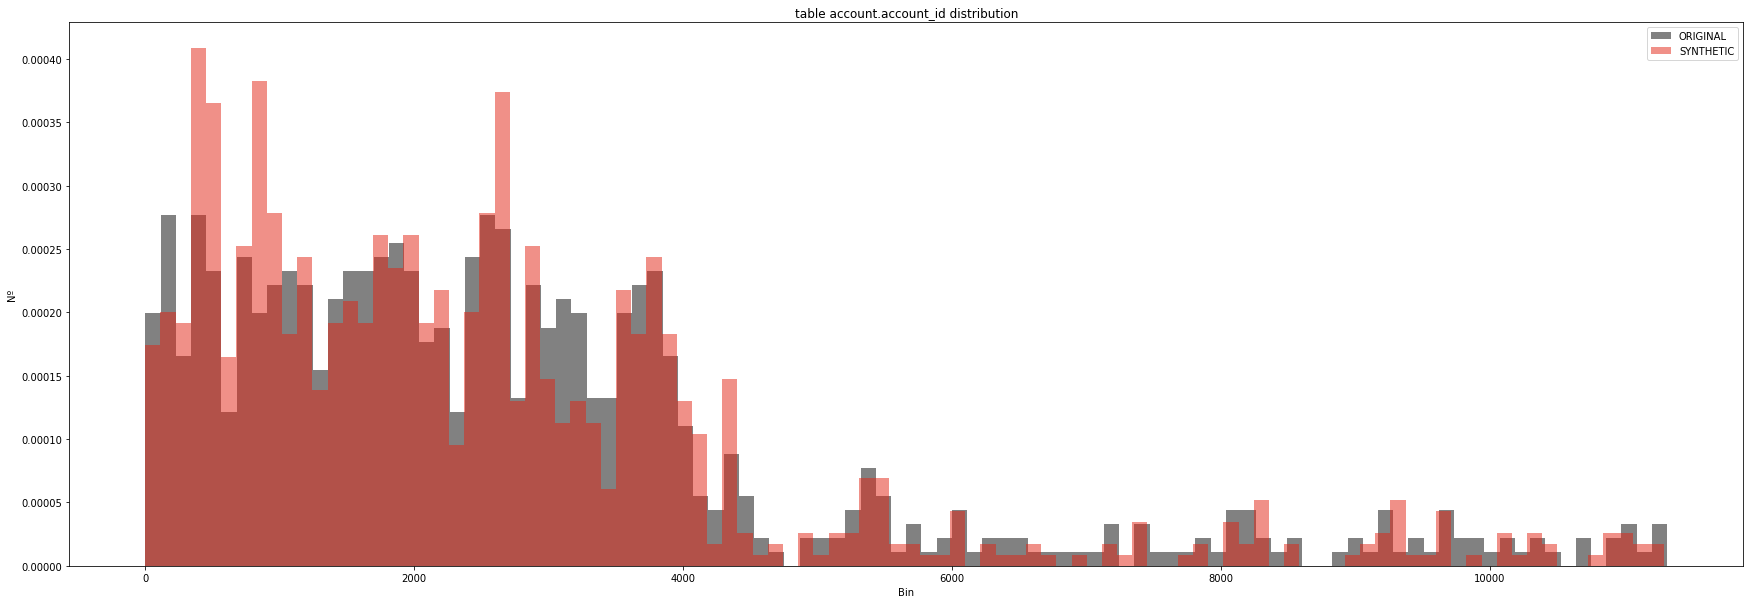

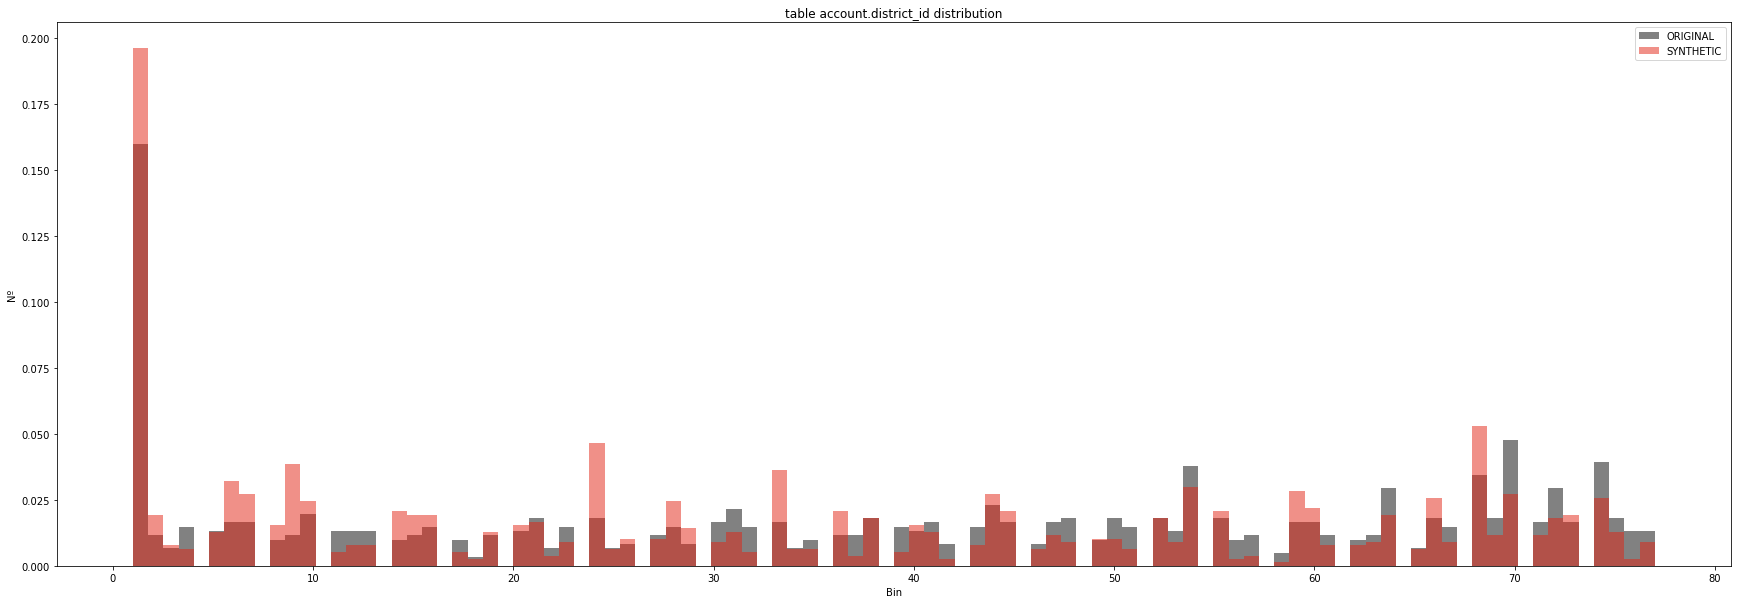

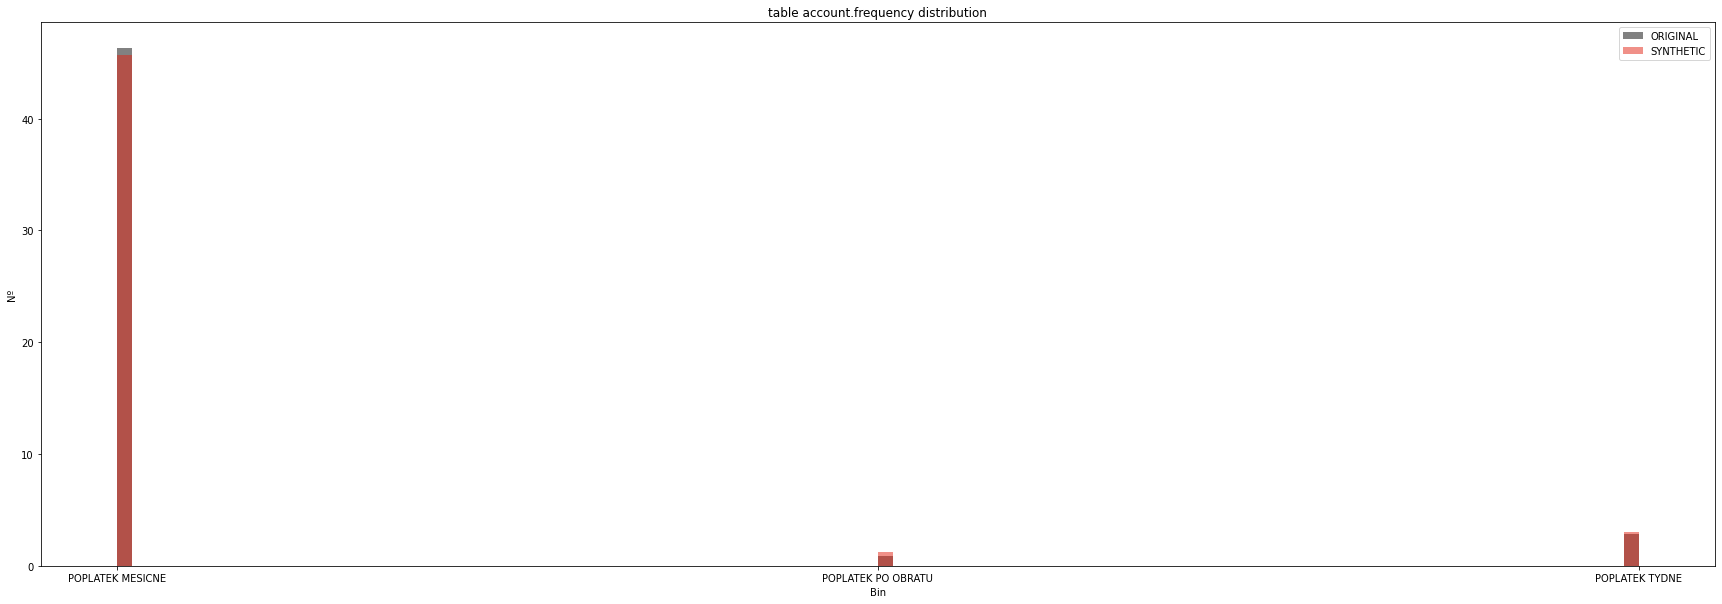

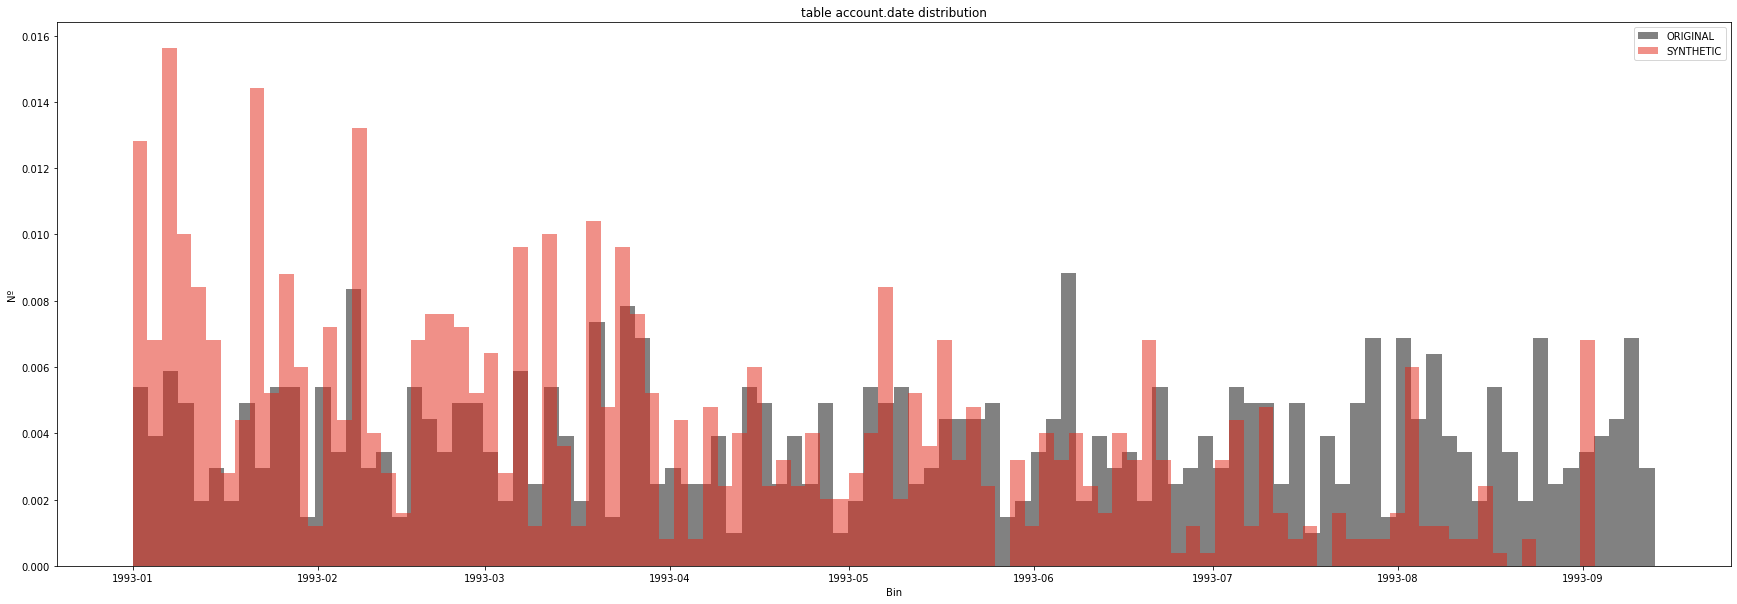

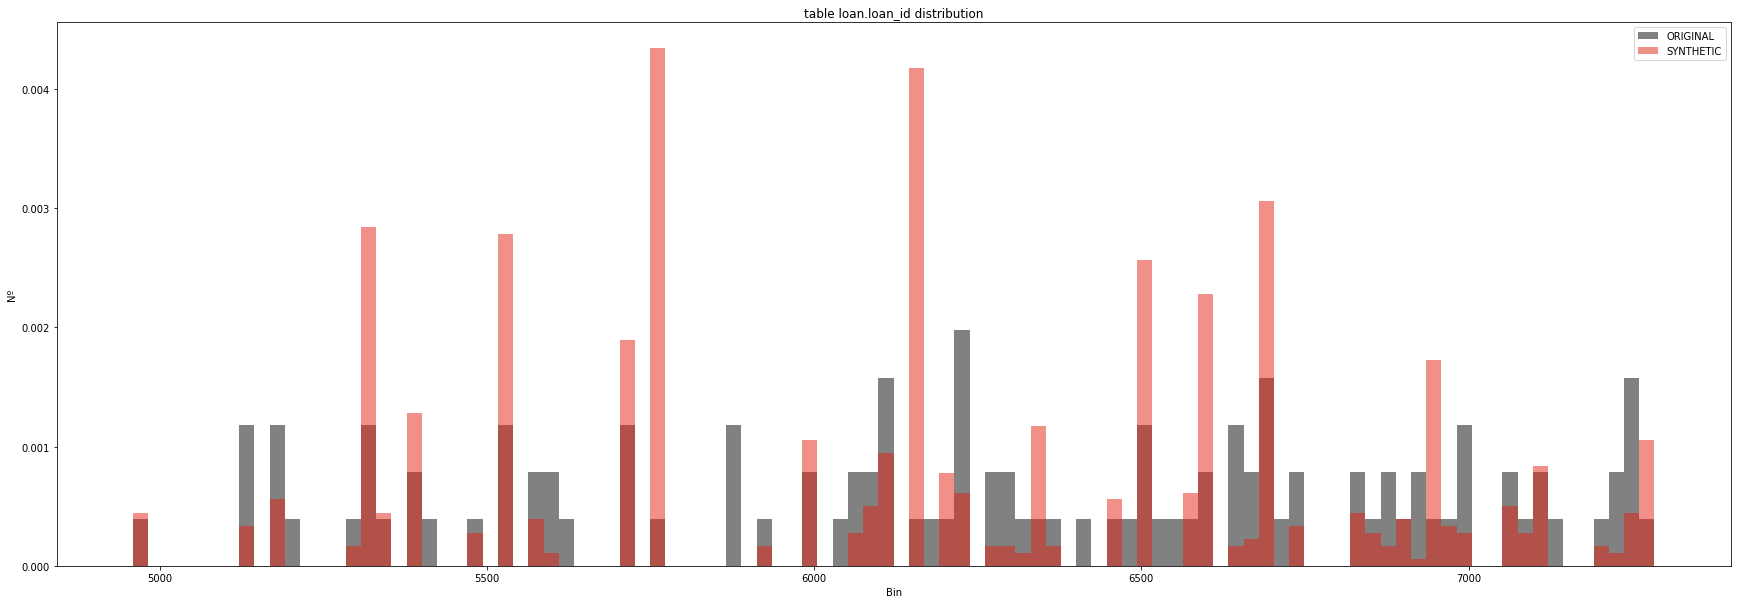

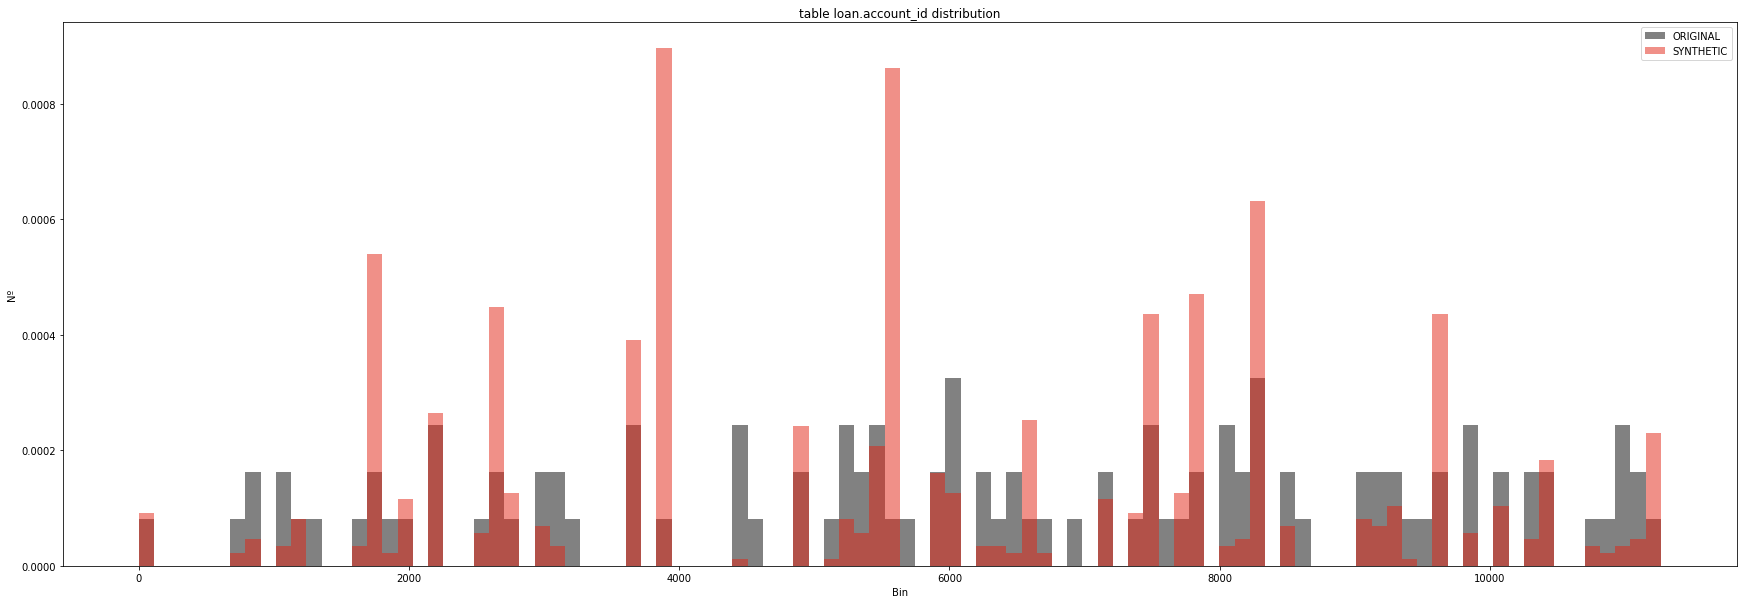

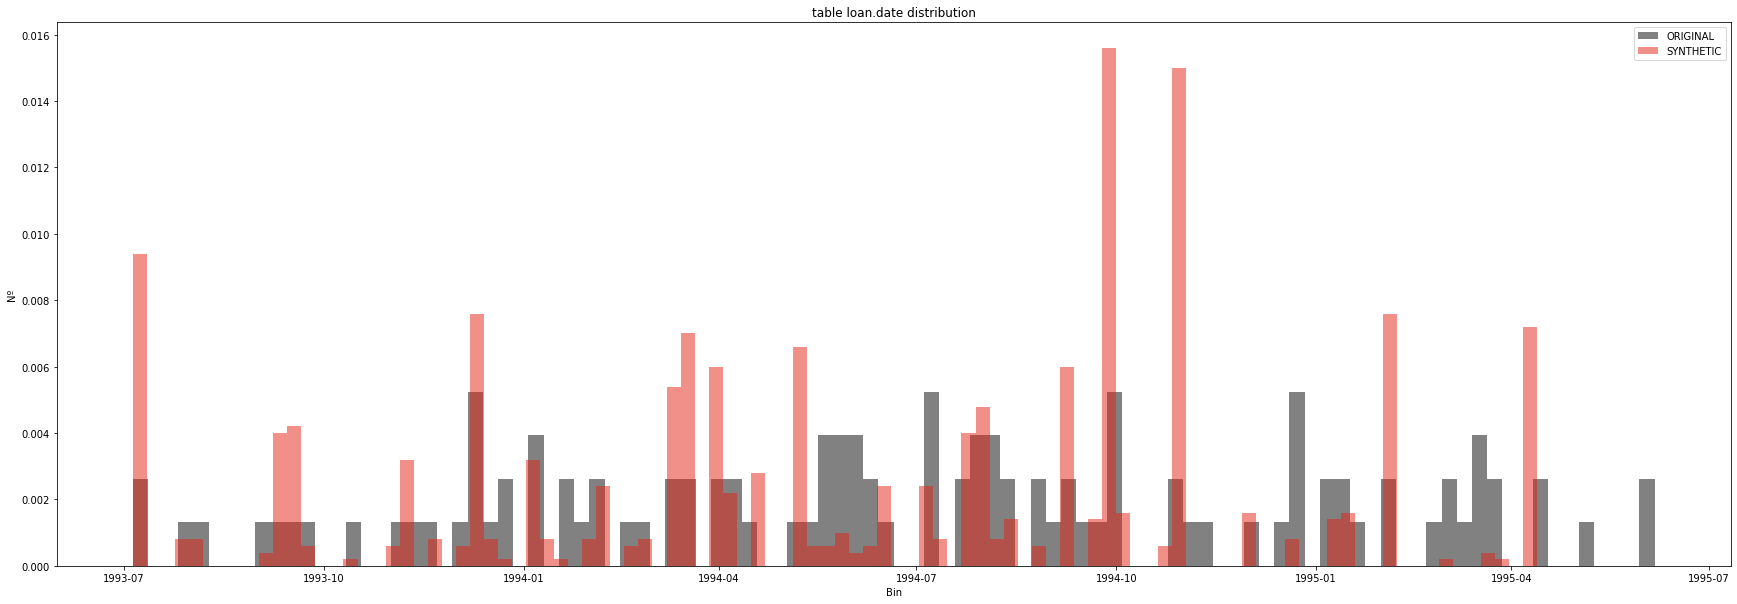

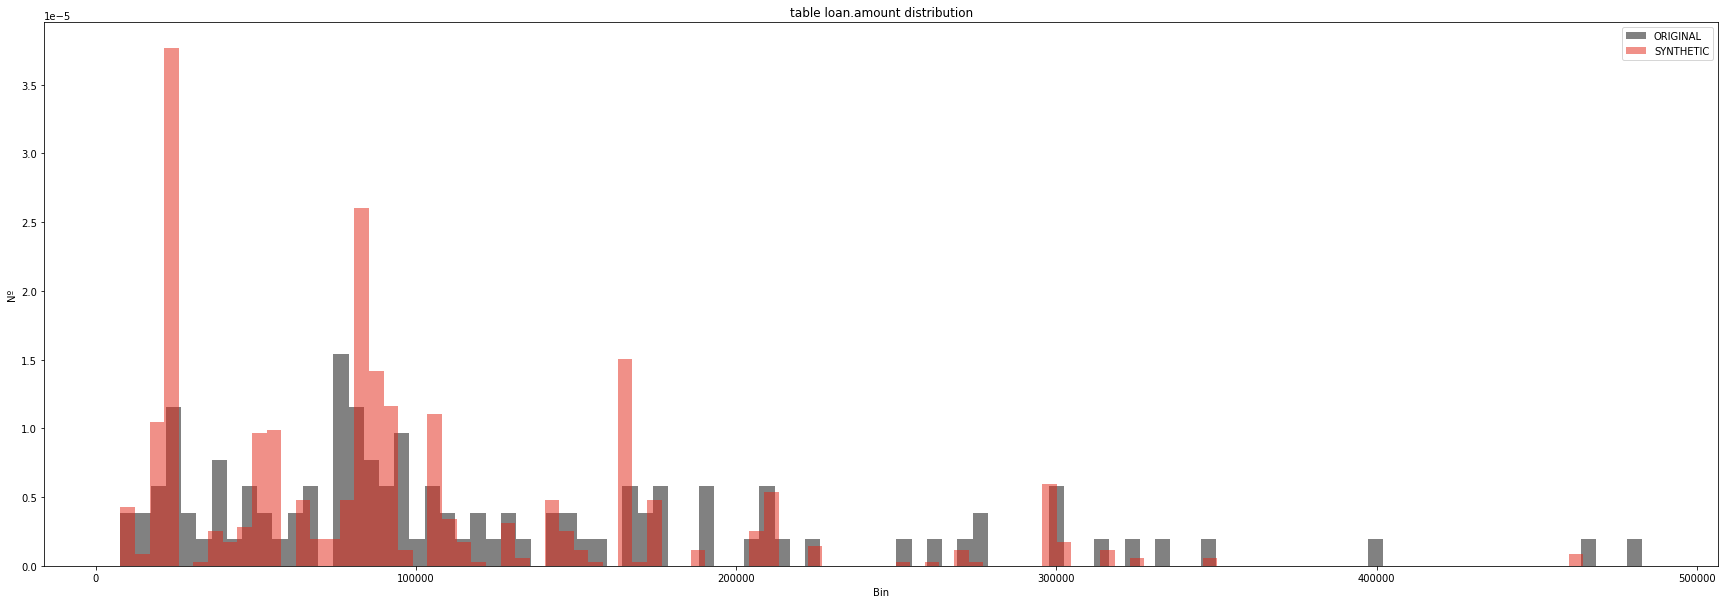

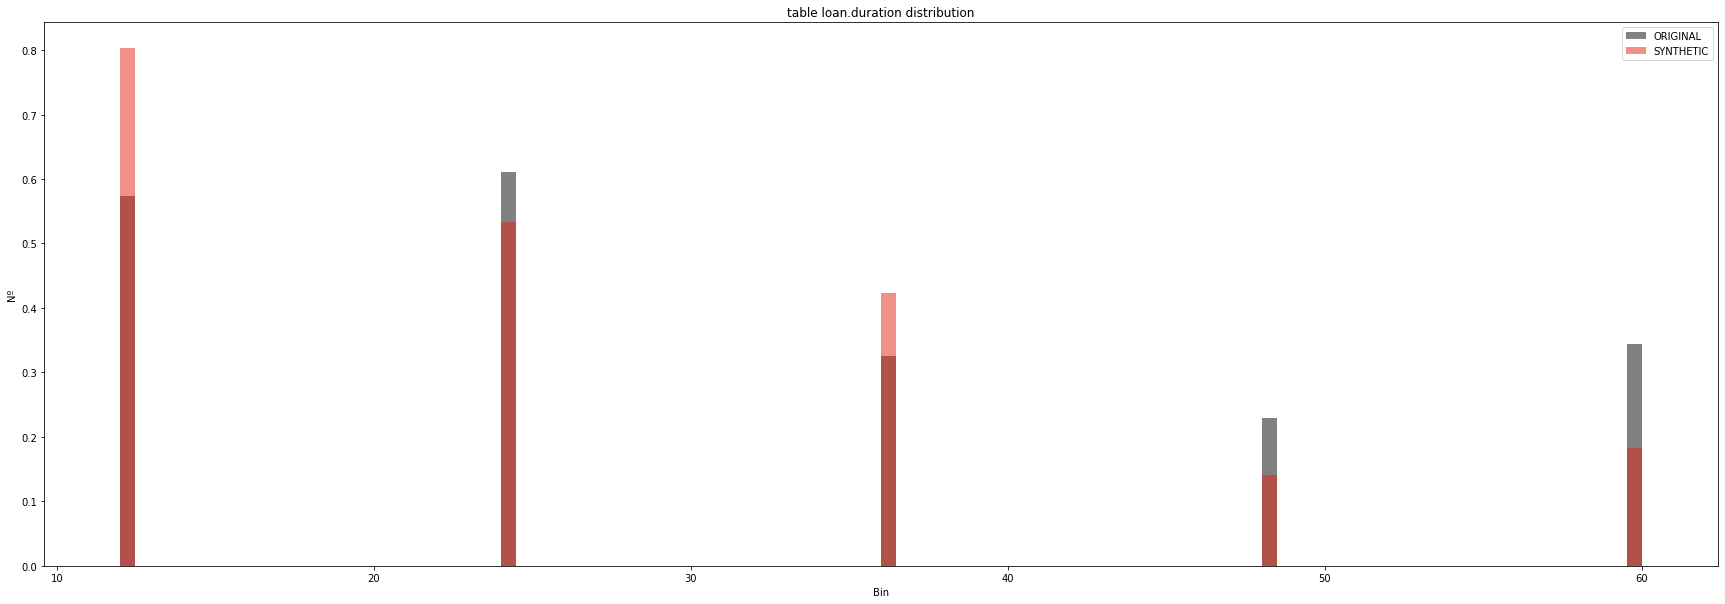

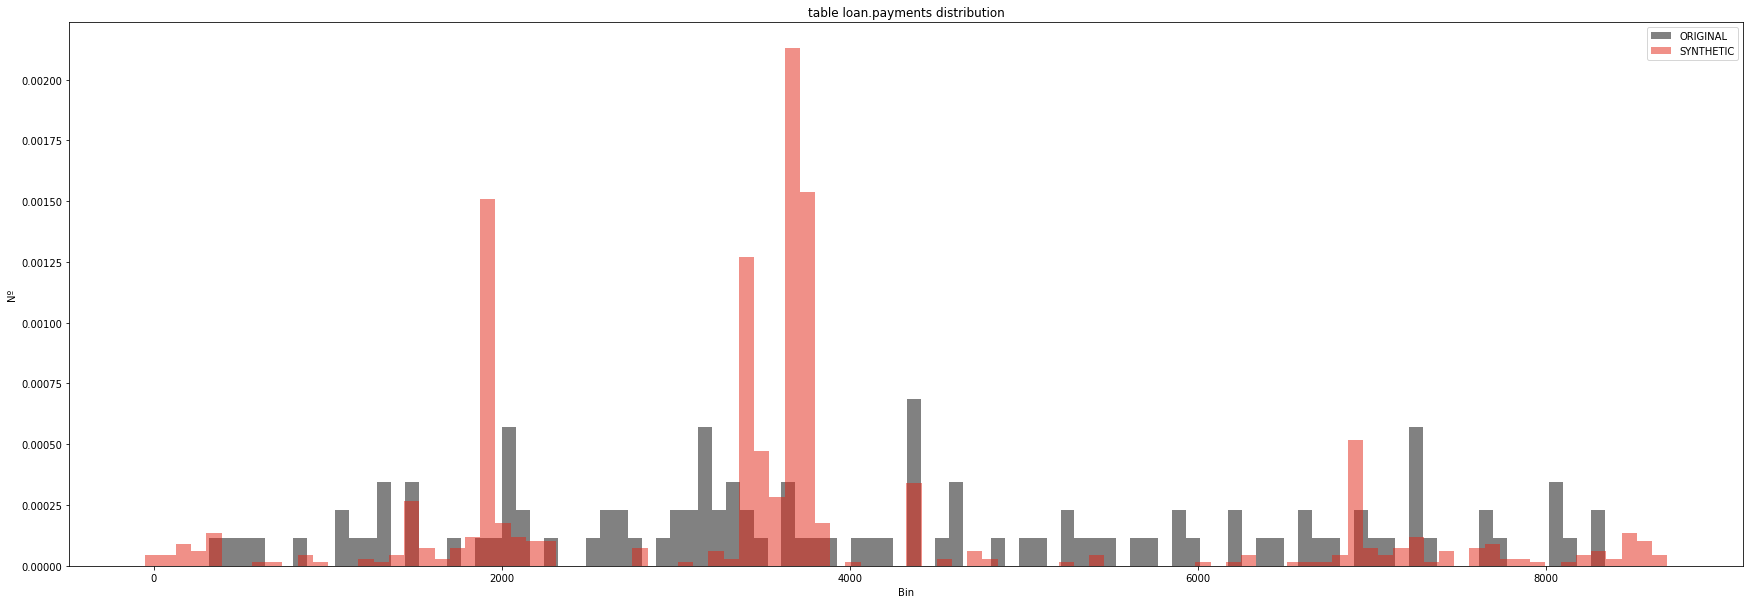

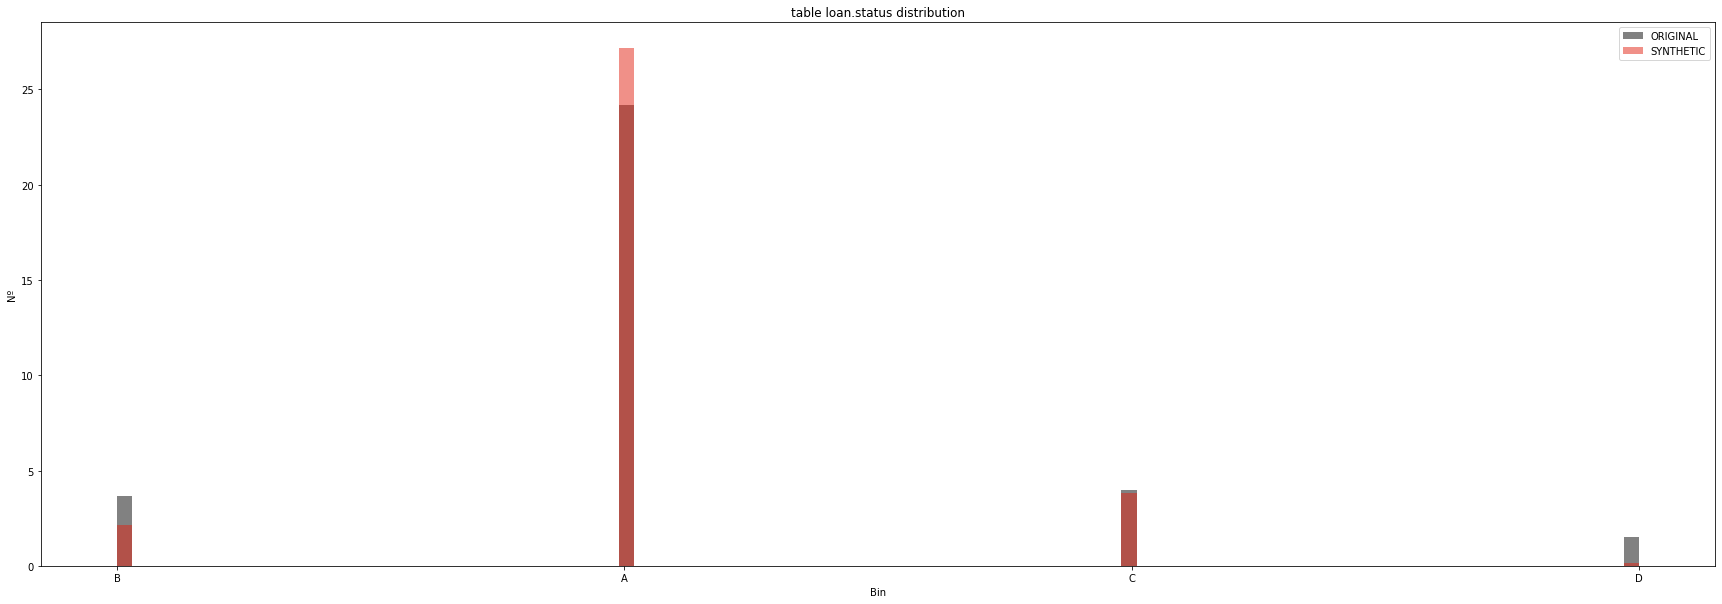

In [31]:
import matplotlib.pyplot as plt
for T in sample.keys():
    for c in berka_tables[T].columns:
        plt.figure(figsize=[30, 10])
        plt.title(f"table {T}.{c} distribution")
        data[T].to_pandas()[c].hist(color="#040404", label="ORIGINAL", grid=False, bins=100, alpha=0.5, density=True)
        sample[T].to_pandas()[c].hist(color="#E32212", label="SYNTHETIC", grid=False, bins=100, alpha=0.5, density=True)
        plt.xlabel("Bin")
        plt.ylabel("Nº")
        plt.legend()
        plt.show()